## 0. Loading Packages

In [1]:
## Loading Modules

import sys, subprocess, os, time, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvi
import scipy
import celltypist
import anndata as ad

from scvi.model.utils import mde
from anndata import AnnData
from celltypist import models
from scipy.sparse import csr_matrix, issparse
from scipy.stats import median_abs_deviation

#### For using R

import rpy2
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as robjects
# rcb.logger.setLevel(logging.ERROR)
robjects.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

import milopy
import milopy.core as milo
import milopy.plot as milopl
import milopy.utils
import pertpy as pt

/mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/sc_24.01/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/sc_24.01/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
cffi mode is CFFI_MODE.ANY
R home found: /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/sc_24.01/lib/R
R library path: 
LD_LIBRARY_PATH: 
Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.


To use sccoda or tasccoda please install ete3 with pip install ete3

In [2]:
#### Session Information

print("=" * 50)
print("Start time :", time.ctime())
print("Sever :", subprocess.check_output("uname -a", shell=True, universal_newlines=True).split()[1])
print("Conda :", subprocess.check_output("conda env list", shell=True, universal_newlines=True))
print("Java :",subprocess.check_output("which java & java -version | sed -n 1p", shell = True, universal_newlines=True))
print("Python :",subprocess.check_output("which python & python --version | sed -n 1p", shell = True, universal_newlines=True))
print("R :",subprocess.check_output("which R & R --version | sed -n 1p", shell = True, universal_newlines=True))
print("Perl :", subprocess.check_output("which perl & perl -version | sed -n 2p", shell = True, universal_newlines=True))
print("=" * 50)

Start time : Sat Apr 12 22:18:18 2025
Sever : gmi-analysis02
Conda : # conda environments:
#
base                     /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3
2023KOGO                 /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/2023KOGO
ASCAT                    /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/ASCAT
Absolute                 /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/Absolute
Bacteria                 /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/Bacteria
Bismark                  /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/Bismark
CNV_25.03                /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CNV_25.03
CNVkit                   /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CNVkit
CTK                      /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CTK
CellChat_23.12           /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CellChat_23.12
CellRank_23.12           /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CellRank_23.12
Celltypist       

openjdk version "1.8.0_362"
OpenJDK Runtime Environment (build 1.8.0_362-b08)
OpenJDK 64-Bit Server VM (build 25.362-b08, mixed mode)


In [3]:
#### Setting

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 120, facecolor = 'White')#### Setting

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.24.4 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11
Running Scanpy 1.9.6, on 2025-04-12 22:18.


## 1. Setting home directory and raw file

In [4]:
## Input Files

path1 = '/data2/Users/hsp224/Project/RNAmethylation/25.04.11_scRNA/Cellranger_9.0.1/'
path2 = '/data2/Users/hsp224/Project/RNAmethylation/25.04.11_scRNA/h5ad/'
path3 = '/data2/Users/hsp224/Project/RNAmethylation/25.04.11_scRNA/h5ad/SCT/'

sample = ['CHR0405', 'CHR0406', 'CHR0407']
os.getcwd()

'/data2/Users/hsp224/Pipeline/RNAmethylation/scRNA'

## 2. scAR : single-cell Ambient Remover

In [5]:
%%time
## Data loading

data = []
data_raw = []
for i in range(0, len(sample)) :
    print(f'{sample[i]} sample loading ..')
    print(time.ctime())
    print('=' * 50)
    
    data.append(sc.read_10x_mtx(path1 + sample[i] + '/outs/filtered_feature_bc_matrix/', 
                                var_names = 'gene_symbols', cache = True))
    data[i].var_names_make_unique()
    print(f'{sample[i]} data : {data[i]}')
    data_raw.append(sc.read_10x_mtx(path1 + sample[i] + '/outs/raw_feature_bc_matrix/', 
                                    var_names = 'gene_symbols', cache = True))
    data_raw[i].var_names_make_unique()
    print(f'{sample[i]} raw data : {data_raw[i]}') 
    print('=' * 50)

CHR0405 sample loading ..
Sat Apr 12 04:42:04 2025
... writing an h5ad cache file to speedup reading next time
CHR0405 data : AnnData object with n_obs × n_vars = 17292 × 33696
    var: 'gene_ids', 'feature_types'
... writing an h5ad cache file to speedup reading next time
CHR0405 raw data : AnnData object with n_obs × n_vars = 1897981 × 33696
    var: 'gene_ids', 'feature_types'
CHR0406 sample loading ..
Sat Apr 12 04:45:22 2025
... writing an h5ad cache file to speedup reading next time
CHR0406 data : AnnData object with n_obs × n_vars = 19665 × 33696
    var: 'gene_ids', 'feature_types'
... writing an h5ad cache file to speedup reading next time
CHR0406 raw data : AnnData object with n_obs × n_vars = 1720252 × 33696
    var: 'gene_ids', 'feature_types'
CHR0407 sample loading ..
Sat Apr 12 04:48:56 2025
... writing an h5ad cache file to speedup reading next time
CHR0407 data : AnnData object with n_obs × n_vars = 15366 × 33696
    var: 'gene_ids', 'feature_types'
... writing an h5ad 

In [6]:
## Save raw count
for i in range(0, len(sample)) :
    data[i].layers['counts'] = data[i].X.copy()
    data[i].obs['barcode'] = data[i].obs.index
    data[i].obs['orig.ident'] = sample[i]

Unable to initialize backend 'cuda': 
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


CHR0405 sample start scAR ..
Sat Apr 12 04:52:02 2025


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Randomly sampling 50000 droplets to calculate the ambient profile.
Working...: 100%|██████████| 3/3 [00:46<00:00, 15.52s/it]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 357/1000:  36%|███▌      | 357/1000 [2:02:30<3:40:38, 20.59s/it, v_num=1, train_loss_step=7.49e+3, train_loss_epoch=7.05e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 7395.185. Signaling Trainer to stop.


... storing 'orig.ident' as categorical
... storing 'feature_types' as categorical


CHR0406 sample start scAR ..
Sat Apr 12 06:56:34 2025
Randomly sampling 50000 droplets to calculate the ambient profile.
Working...: 100%|██████████| 3/3 [00:53<00:00, 17.83s/it]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 448/1000:  45%|████▍     | 448/1000 [3:08:46<3:52:35, 25.28s/it, v_num=1, train_loss_step=6.22e+3, train_loss_epoch=6.8e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 6923.773. Signaling Trainer to stop.


... storing 'orig.ident' as categorical
... storing 'feature_types' as categorical


CHR0407 sample start scAR ..
Sat Apr 12 10:07:23 2025
Randomly sampling 50000 droplets to calculate the ambient profile.
Working...: 100%|██████████| 3/3 [00:43<00:00, 14.64s/it]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 326/1000:  33%|███▎      | 326/1000 [1:34:41<3:15:47, 17.43s/it, v_num=1, train_loss_step=9.19e+3, train_loss_epoch=7.38e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 7545.385. Signaling Trainer to stop.


... storing 'orig.ident' as categorical
... storing 'feature_types' as categorical


CPU times: user 7h 9min 26s, sys: 27min 25s, total: 7h 36min 51s
Wall time: 6h 51min 38s


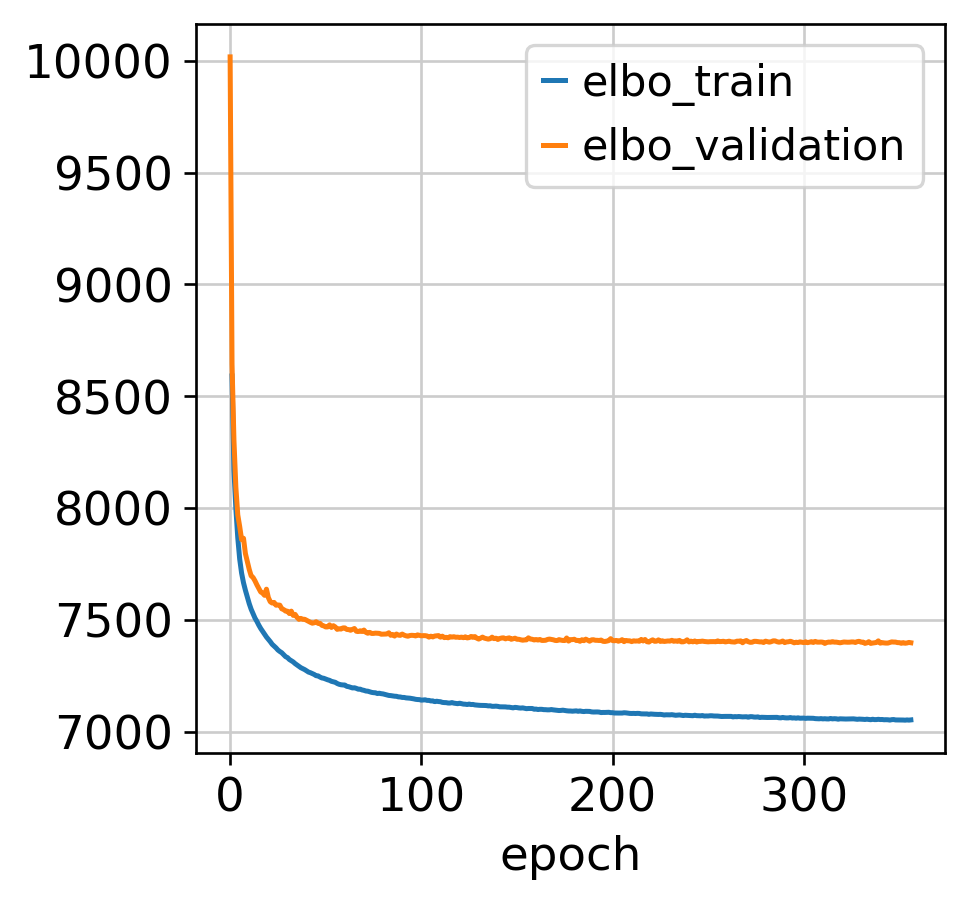

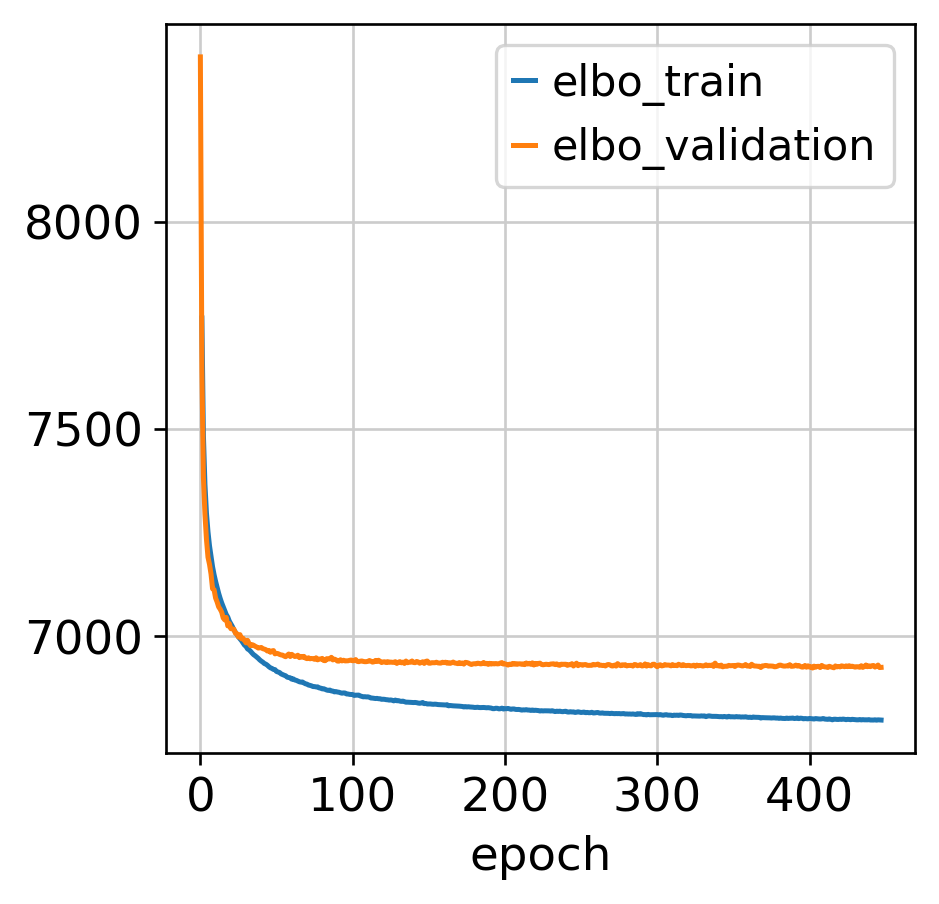

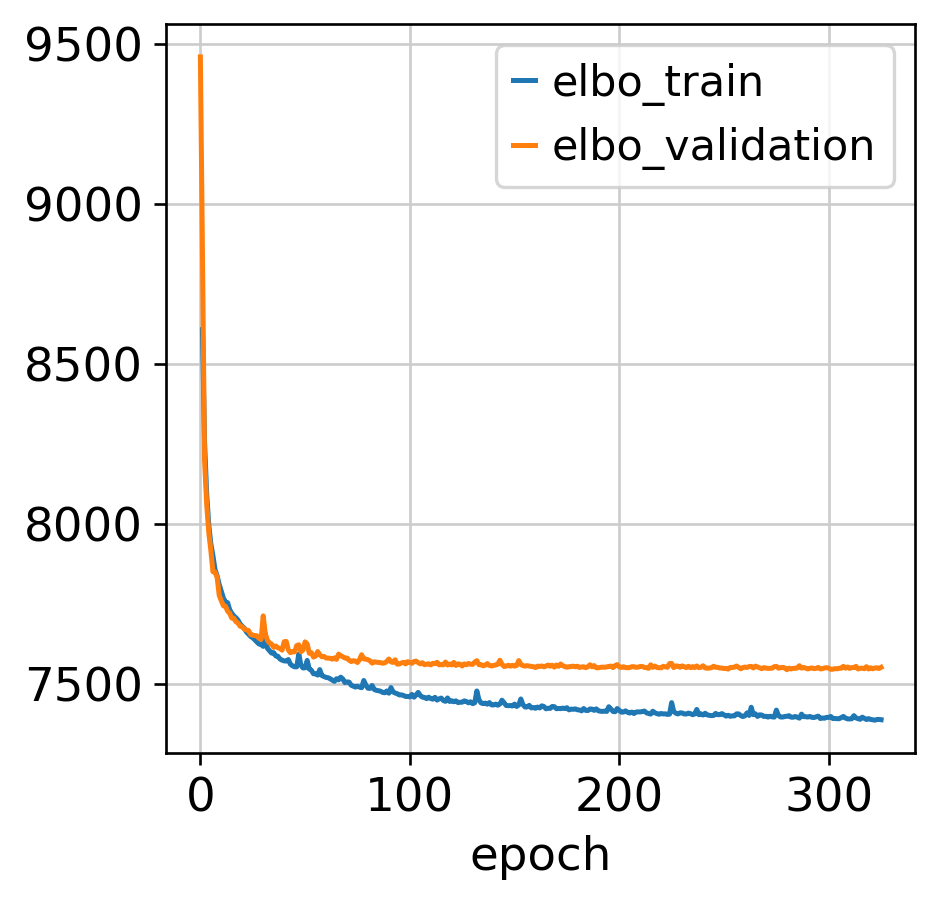

In [7]:
%%time
vae_scvi = []

for i in range(0, len(sample)) :
    
    print(f'{sample[i]} sample start scAR ..')
    print(time.ctime())
    print('=' * 50)
    
    scvi.external.SCAR.setup_anndata(data[i])
    
    ## Calculate ambient profile for relevant features.
    scvi.external.SCAR.get_ambient_profile(adata = data[i], 
                                           raw_adata = data_raw[i], 
                                           prob = 0.995)
    
    vae_scvi.append(scvi.external.SCAR(data[i], ambient_profile = "ambient_profile"))
    vae_scvi[i].train(max_epochs = 1000, early_stopping = True, check_val_every_n_epoch = 10)
    
    train_elbo = vae_scvi[i].history["elbo_train"][1:]
    test_elbo = vae_scvi[i].history["elbo_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax = ax)
    
    ## Return the latent representation for each cell.
    data[i].obsm['X_scAR'] = vae_scvi[i].get_latent_representation()
    
    ## Generate observation samples from the posterior predictive distribution.
    data[i].layers['denoised'] = vae_scvi[i].get_denoised_counts()
    
    ## apply scAR ouput 
    data[i].X = data[i].layers['denoised']
    
    ## save files
    data[i].write(path2 + sample[i] + '.scAR.h5ad')
    print('=' * 50)

## 3. Solo - Doublet detection via semi-supervised deep learning

### 3-1. Doublet ratio 1 ver

In [6]:
## Read raw files
data = []

for i in range(0, len(sample)) :
    data.append(sc.read_h5ad(path2 + sample[i] + '.scAR.h5ad'))

In [8]:
## Check whether .X data is denoised or not
data[0].X

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

CHR0405 sample start Solo ..
Sat Apr 12 11:43:41 2025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 572/600:  95%|█████████▌| 572/600 [37:27<01:50,  3.93s/it, v_num=1, train_loss_step=5.2e+3, train_loss_epoch=5.46e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 5482.380. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 308/1200:  26%|██▌       | 308/1200 [03:18<09:36,  1.55it/s, v_num=1, train_loss_step=0.253, train_loss_epoch=0.295]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.283. Signaling Trainer to stop.


... storing 'res_solo' as categorical


CHR0406 sample start Solo ..
Sat Apr 12 12:24:49 2025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 499/600:  83%|████████▎ | 499/600 [36:55<07:28,  4.44s/it, v_num=1, train_loss_step=5.43e+3, train_loss_epoch=5.37e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 5427.514. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 366/1200:  30%|███       | 366/1200 [04:29<10:13,  1.36it/s, v_num=1, train_loss_step=0.416, train_loss_epoch=0.289]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.275. Signaling Trainer to stop.


... storing 'res_solo' as categorical


CHR0407 sample start Solo ..
Sat Apr 12 13:06:38 2025


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 600/600: 100%|██████████| 600/600 [34:37<00:00,  3.41s/it, v_num=1, train_loss_step=6.34e+3, train_loss_epoch=5.62e+3]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [34:37<00:00,  3.46s/it, v_num=1, train_loss_step=6.34e+3, train_loss_epoch=5.62e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 240/1200:  20%|██        | 240/1200 [02:19<09:17,  1.72it/s, v_num=1, train_loss_step=0.615, train_loss_epoch=0.248] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.231. Signaling Trainer to stop.


... storing 'res_solo' as categorical


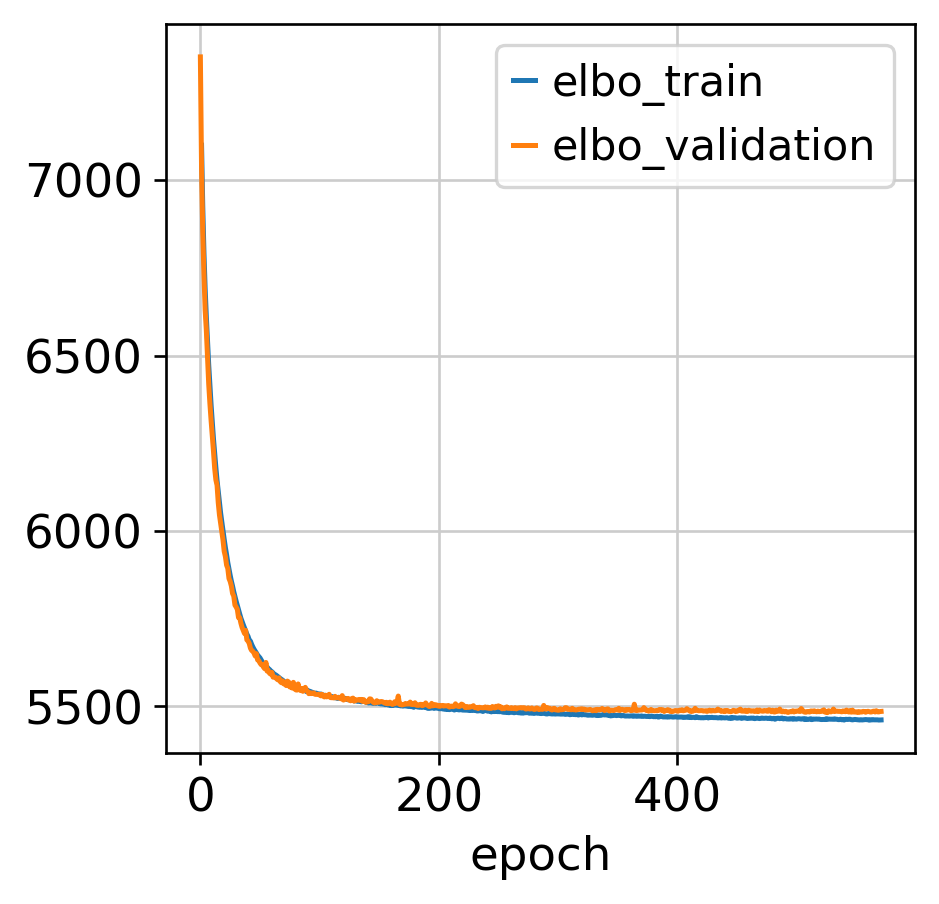

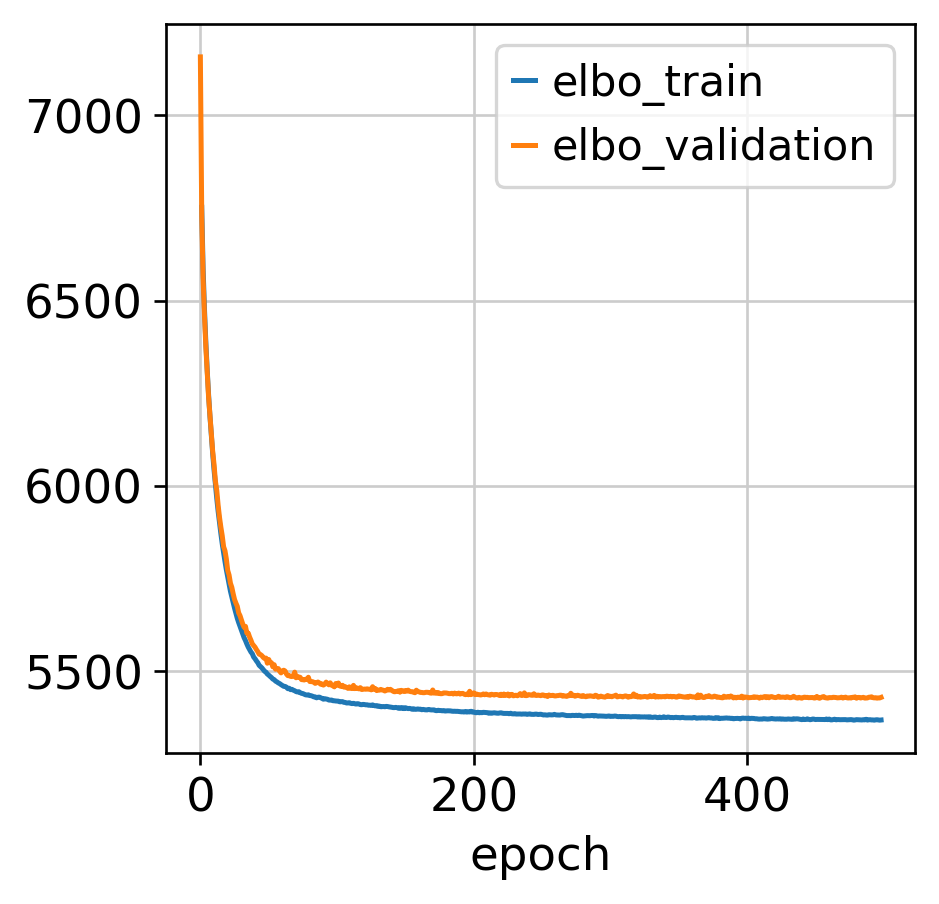

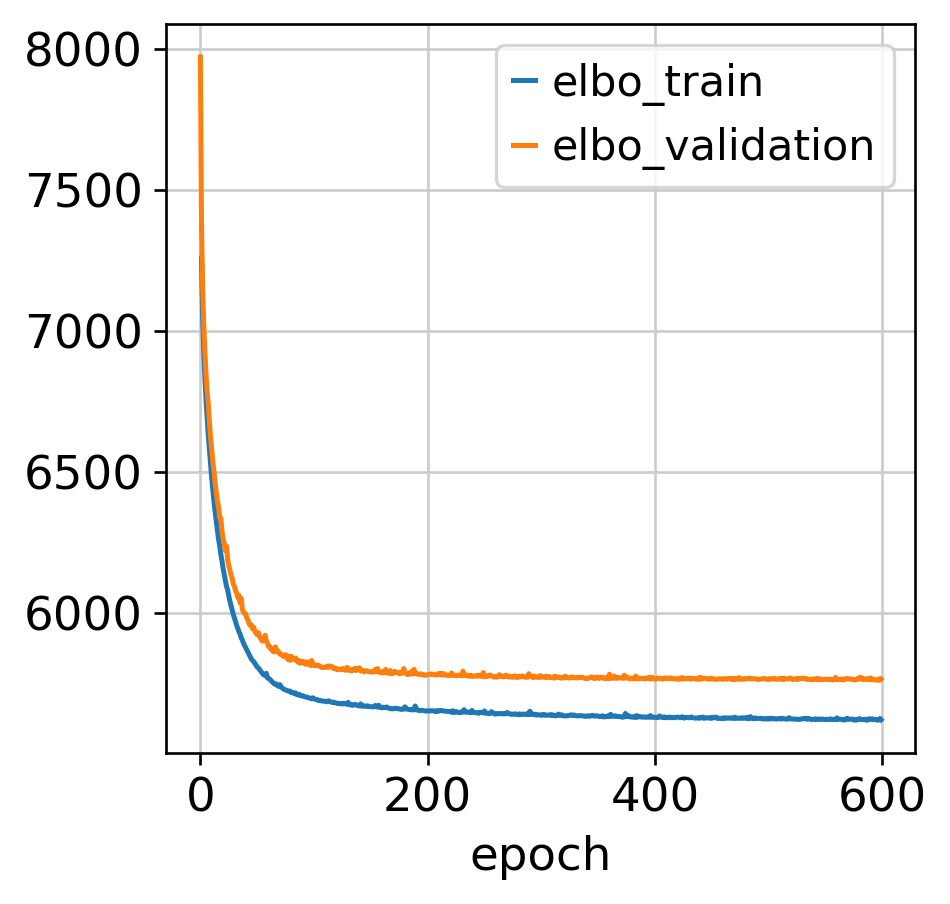

In [9]:
vae_solo = []
solo = []
res_solo = []

for i in range(0, len(sample)) :
    
    print(f'{sample[i]} sample start Solo ..')
    print(time.ctime())
    print('=' * 50)
    
    scvi.model.SCVI.setup_anndata(data[i])
    vae_solo.append(scvi.model.SCVI(data[i]))
    vae_solo[i].train(max_epochs = 600, early_stopping = True, check_val_every_n_epoch = 10)
    
    train_elbo = vae_solo[i].history["elbo_train"][1:]
    test_elbo = vae_solo[i].history["elbo_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax = ax)
    
    ## Instantiate a SOLO model from an scvi model and trains the model.
    solo.append(scvi.external.SOLO.from_scvi_model(vae_solo[i], doublet_ratio = 1))
    solo[i].train(max_epochs = 1200, early_stopping = True, check_val_every_n_epoch = 10)
    
    ## Return doublet predictions.
    res_solo.append(solo[i].predict())
    res_solo[i]['res_solo'] = solo[i].predict(soft = False)
    # res_solo[i].index = res_solo[i].index.str[:-2]
    res_solo[i]['barcode'] = res_solo[i].index
    data[i].obs = pd.merge(data[i].obs, res_solo[i], how = 'inner', on = 'barcode')
    data[i].obs.index = list(data[i].obs['barcode'])
    
    ## save files
    data[i].write(path2 + sample[i] + '.scAR.solo1.h5ad')
    print('=' * 50)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:19)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)
running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
CHR0405 sample information 
total : 17292 
singlet : 15538 
doublet : 1754 
doublet % : 10.14%


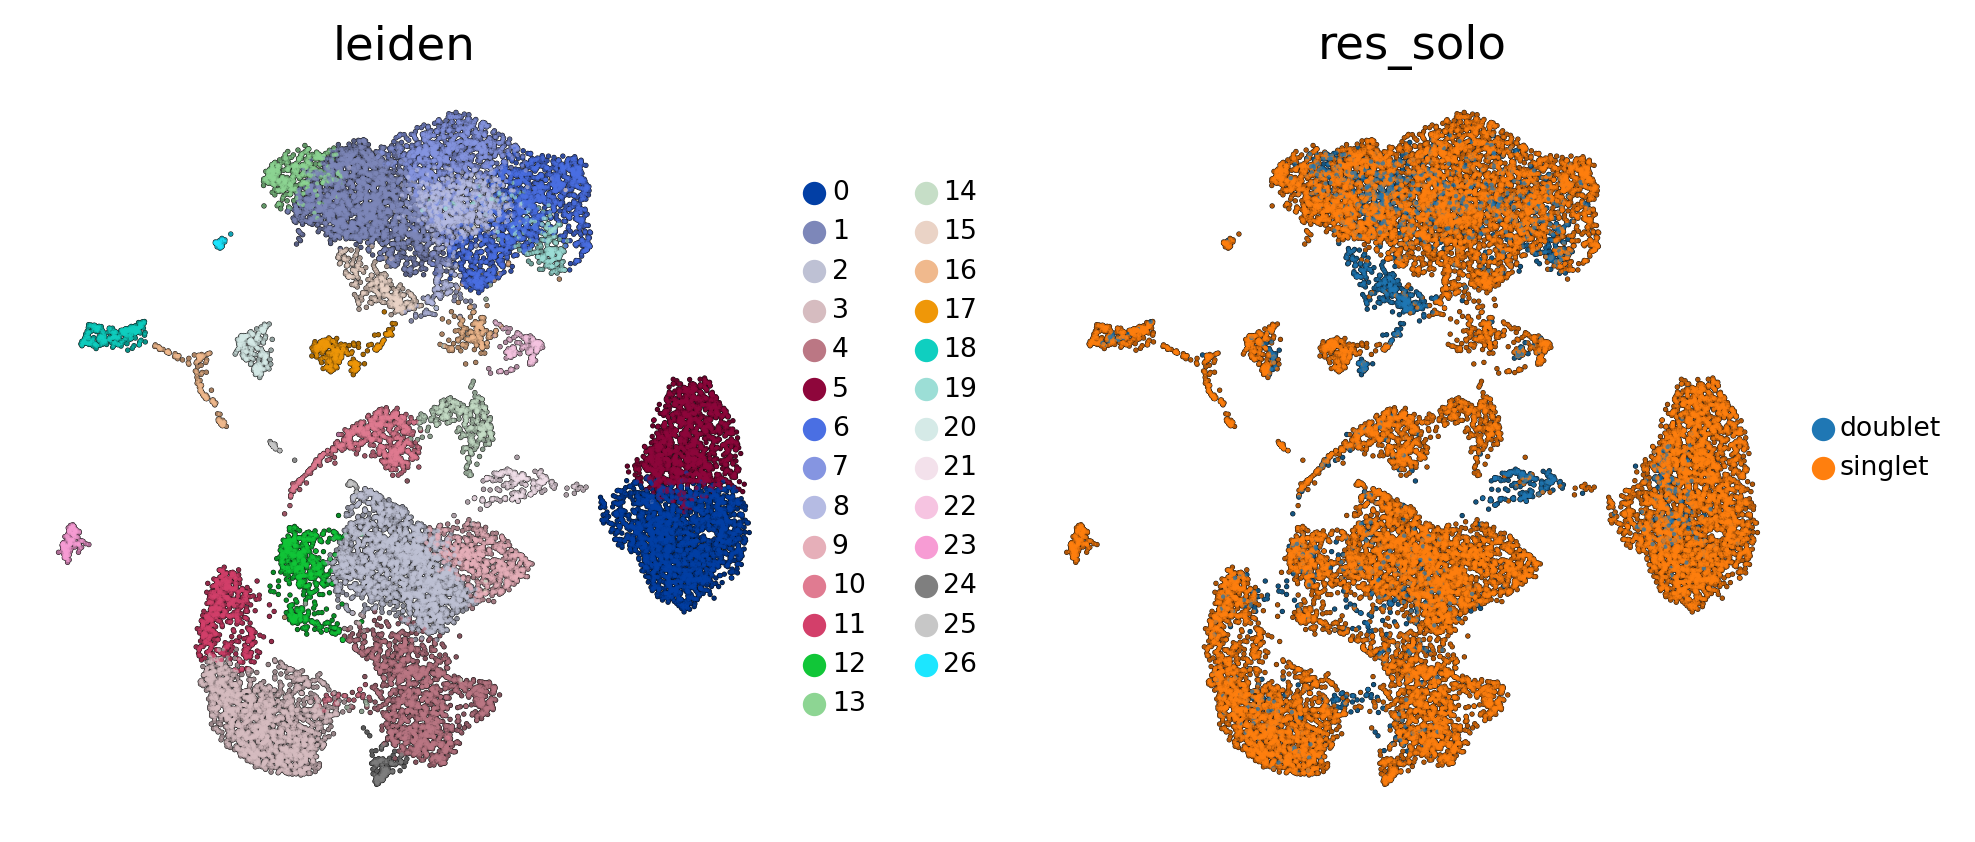

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
CHR0406 sample information 
total : 19665 
singlet : 17530 
doublet : 2135 
doublet % : 10.86%


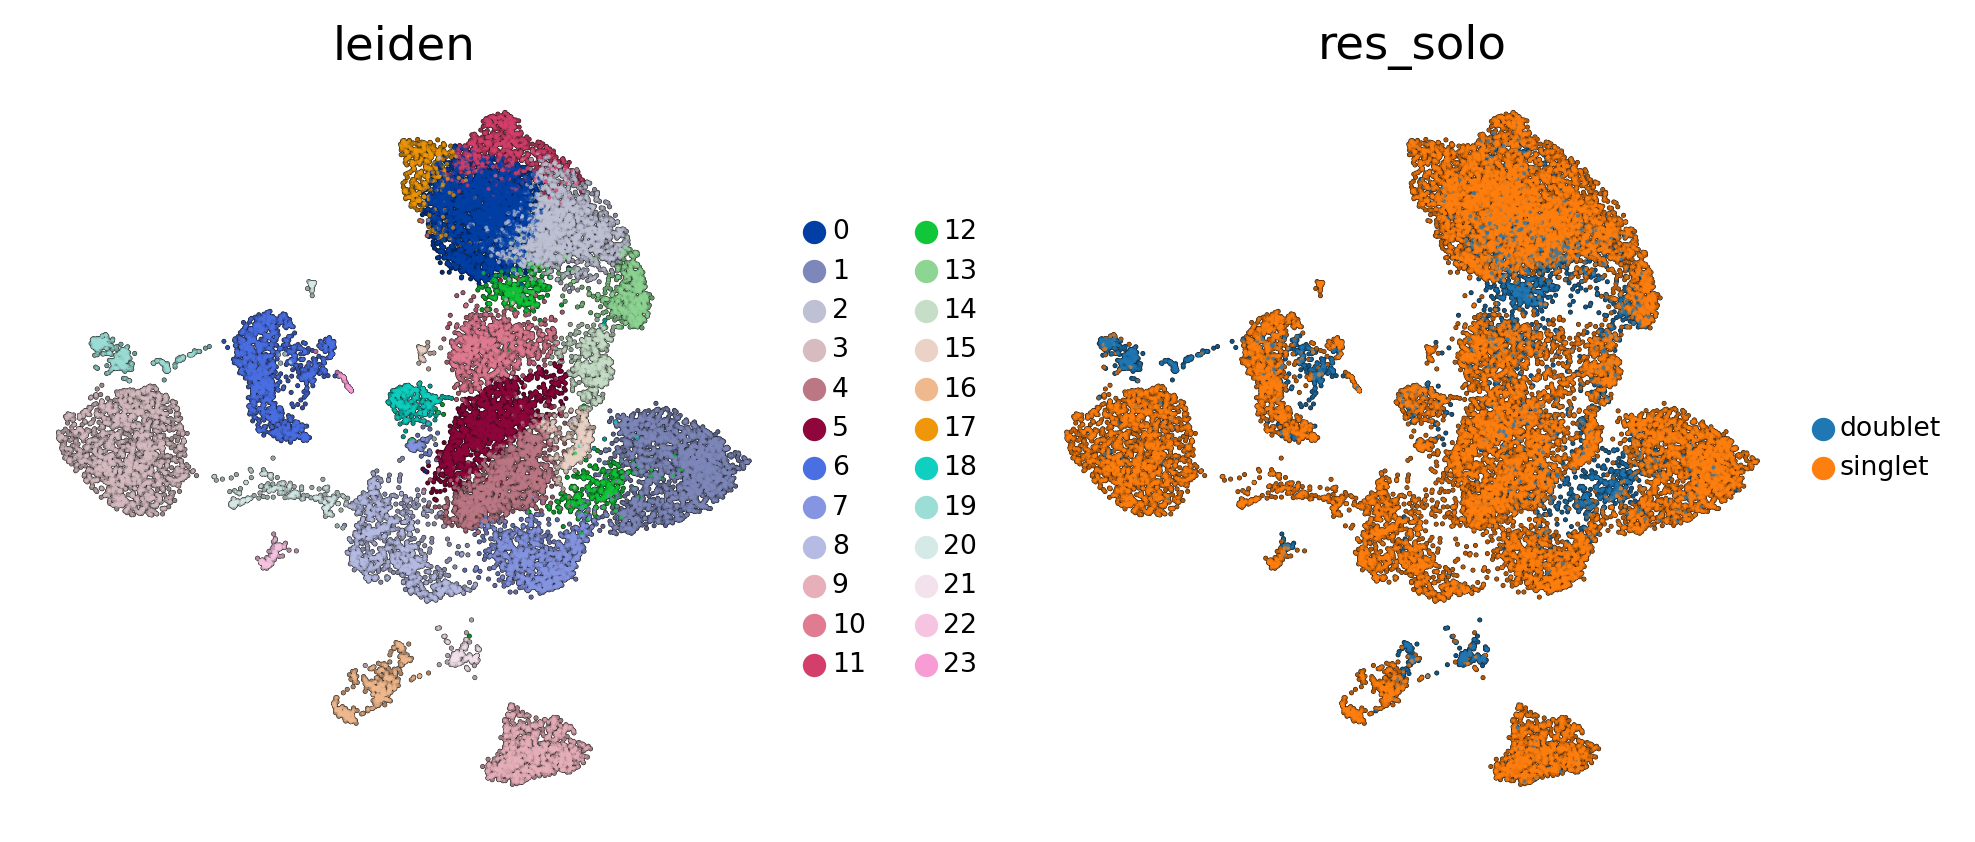

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
CHR0407 sample information 
total : 15366 
singlet : 13939 
doublet : 1427 
doublet % : 9.29%


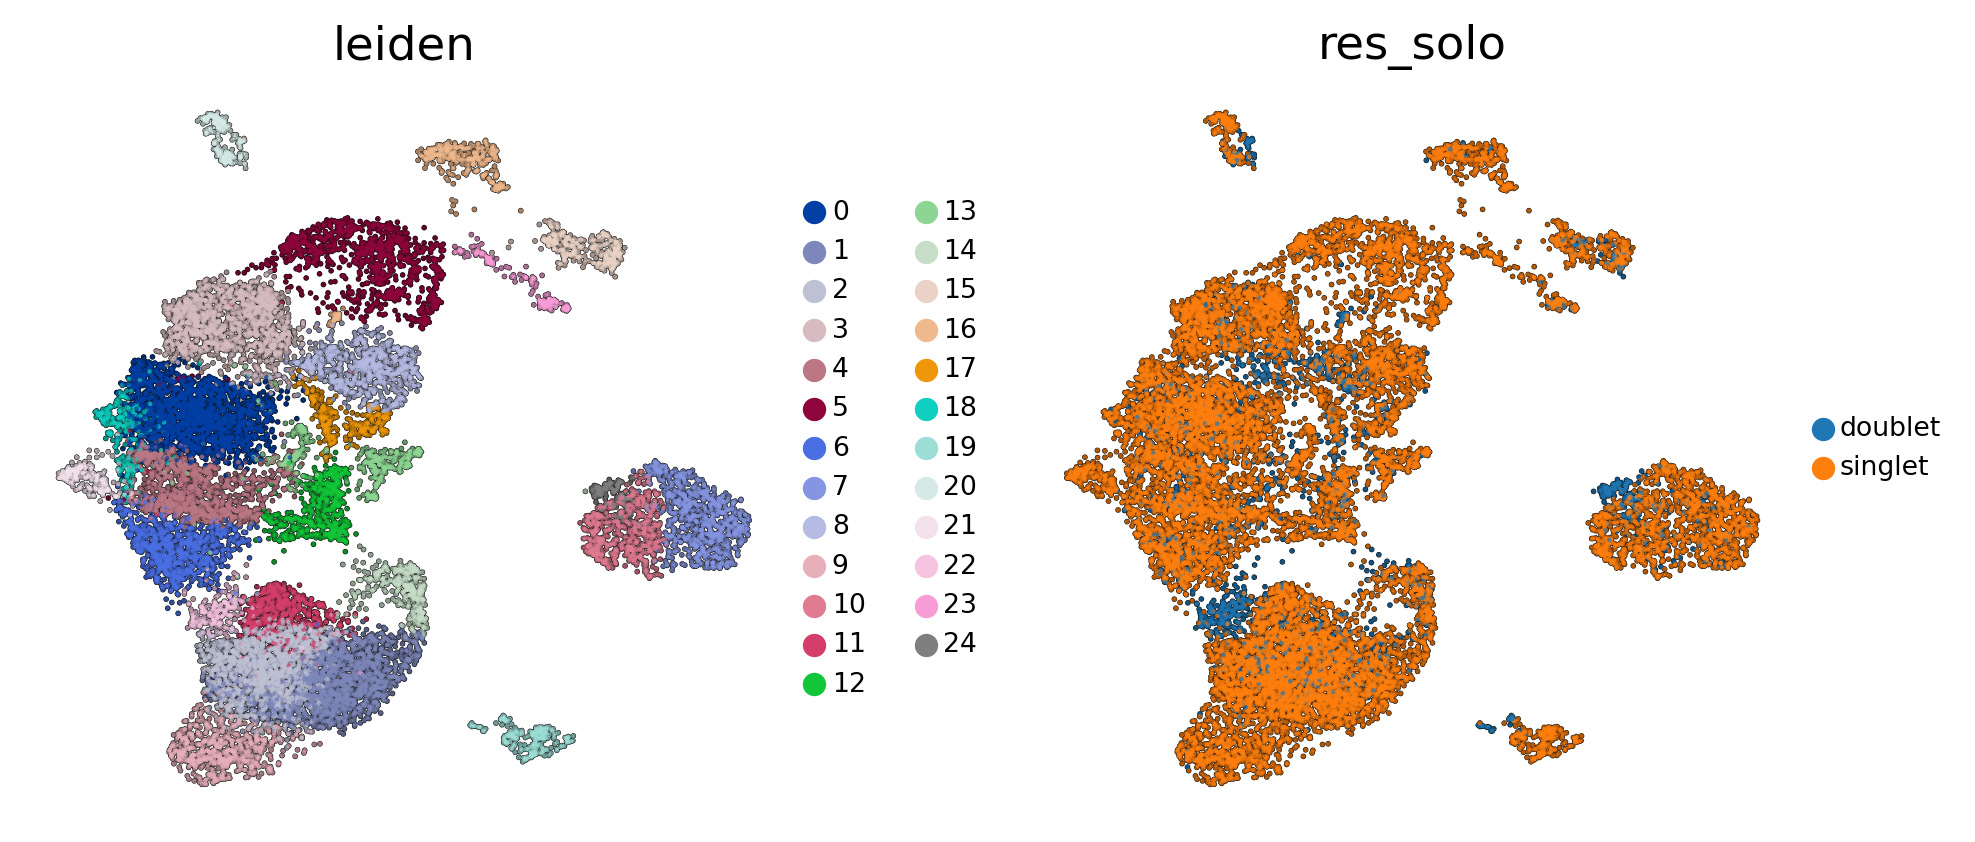

In [10]:
## Visualization doublet and singlet
ex = []

for i in range(0, len(sample)) :
    ex.append(data[i])
    sc.pp.normalize_total(ex[i], target_sum = 1e4)
    sc.pp.log1p(ex[i])
    sc.tl.pca(ex[i])
    sc.pp.neighbors(ex[i])
    sc.tl.umap(ex[i])
    sc.tl.leiden(ex[i], resolution = 1)
    print('=' * 50)
    print(f'{sample[i]} sample information \ntotal : {len(data[i].obs)} \nsinglet : {len(data[i].obs[data[i].obs["res_solo"] == "singlet"])} \ndoublet : {len(data[i].obs[data[i].obs["res_solo"] == "doublet"])} \ndoublet % : {(len(data[i].obs[data[i].obs["res_solo"] == "doublet"])/len(data[i].obs)):.2%}')
    sc.pl.umap(ex[i], color = ['leiden', 'res_solo'], frameon = False, add_outline = True, outline_width = (0.8, 0.1), outline_color = ('white', 'black'), legend_fontsize = 8, legend_fontoutline = 2, show = True)
    print('=' * 50)

## 4. Preprocessing

In [5]:
## Read raw files
data1 = []

for i in range(0, len(sample)) :
    data1.append(sc.read_h5ad(path2 + sample[i] + '.scAR.solo1.h5ad'))

In [6]:
'''
## Load metadata from souporcell
meta = []
for i in range(0, len(sample)) :
    meta.append(pd.read_csv(path4 + sample[i] + "/clusters.tsv", sep = '\t', engine = 'python', encoding = 'utf-8'))
    print(f'Check {sample[i]} row count : {len(data1[i].obs)} vs {len(meta[i]["barcode"])}')
    print('-' * 50)
'''

'\n## Load metadata from souporcell\nmeta = []\nfor i in range(0, len(sample)) :\n    meta.append(pd.read_csv(path4 + sample[i] + "/clusters.tsv", sep = \'\t\', engine = \'python\', encoding = \'utf-8\'))\n    print(f\'Check {sample[i]} row count : {len(data1[i].obs)} vs {len(meta[i]["barcode"])}\')\n    print(\'-\' * 50)\n'

In [7]:
'''
## add meta data 
for i in range(0, len(sample)) :
    data1[i].obs = pd.merge(data1[i].obs, meta[i][['barcode', 'status', 'assignment']], how = 'inner', on = 'barcode')
    data1[i].obs['cluster'] = data1[i].obs['orig.ident'].astype(str) + '_' + data1[i].obs['assignment'].astype(str)
    data1[i].obs.index = list(data1[i].obs['barcode'])
'''

"\n## add meta data \nfor i in range(0, len(sample)) :\n    data1[i].obs = pd.merge(data1[i].obs, meta[i][['barcode', 'status', 'assignment']], how = 'inner', on = 'barcode')\n    data1[i].obs['cluster'] = data1[i].obs['orig.ident'].astype(str) + '_' + data1[i].obs['assignment'].astype(str)\n    data1[i].obs.index = list(data1[i].obs['barcode'])\n"

In [8]:
## delete doublet from souporcell and solo

print('=' * 50)
for i in range(0, len(sample)) :
    print(f'{sample[i]} sample doublet filter 1 information \ntotal : {len(data1[i].obs)} \nsinglet : {len(data1[i].obs[data1[i].obs["res_solo"] == "singlet"])} \ndoublet : {len(data1[i].obs[data1[i].obs["res_solo"] == "doublet"])} \ndoublet % : {(len(data1[i].obs[data1[i].obs["res_solo"] == "doublet"])/len(data1[i].obs)):.2%}')
    print(f' {sample[i]} raw cell count : {len(data1[i].obs)}')
    data1[i] = data1[i][data1[i].obs['res_solo'] == 'singlet']
    print(f' {sample[i]} doublet-filtered cell count : {len(data1[i].obs)}')
    print('-' * 50)

CHR0405 sample doublet filter 1 information 
total : 17292 
singlet : 15538 
doublet : 1754 
doublet % : 10.14%
 CHR0405 raw cell count : 17292
 CHR0405 doublet-filtered cell count : 15538
--------------------------------------------------
CHR0406 sample doublet filter 1 information 
total : 19665 
singlet : 17530 
doublet : 2135 
doublet % : 10.86%
 CHR0406 raw cell count : 19665
 CHR0406 doublet-filtered cell count : 17530
--------------------------------------------------
CHR0407 sample doublet filter 1 information 
total : 15366 
singlet : 13939 
doublet : 1427 
doublet % : 9.29%
 CHR0407 raw cell count : 15366
 CHR0407 doublet-filtered cell count : 13939
--------------------------------------------------


 CHR0405 doublet ver 1 QC plot top


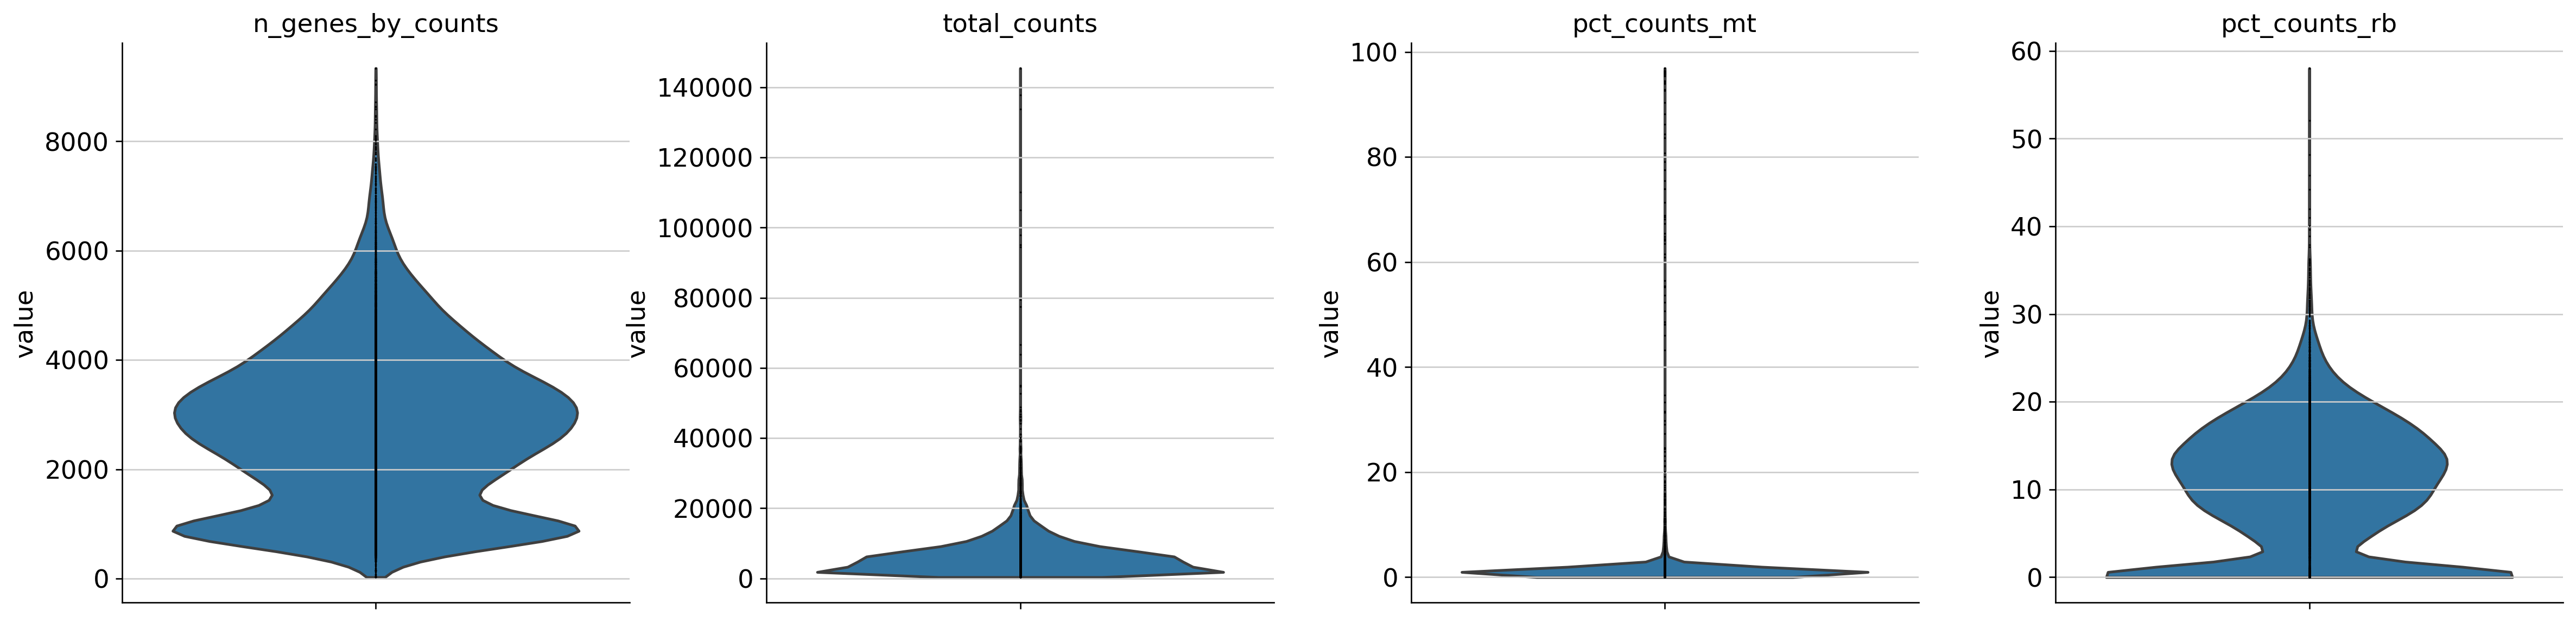

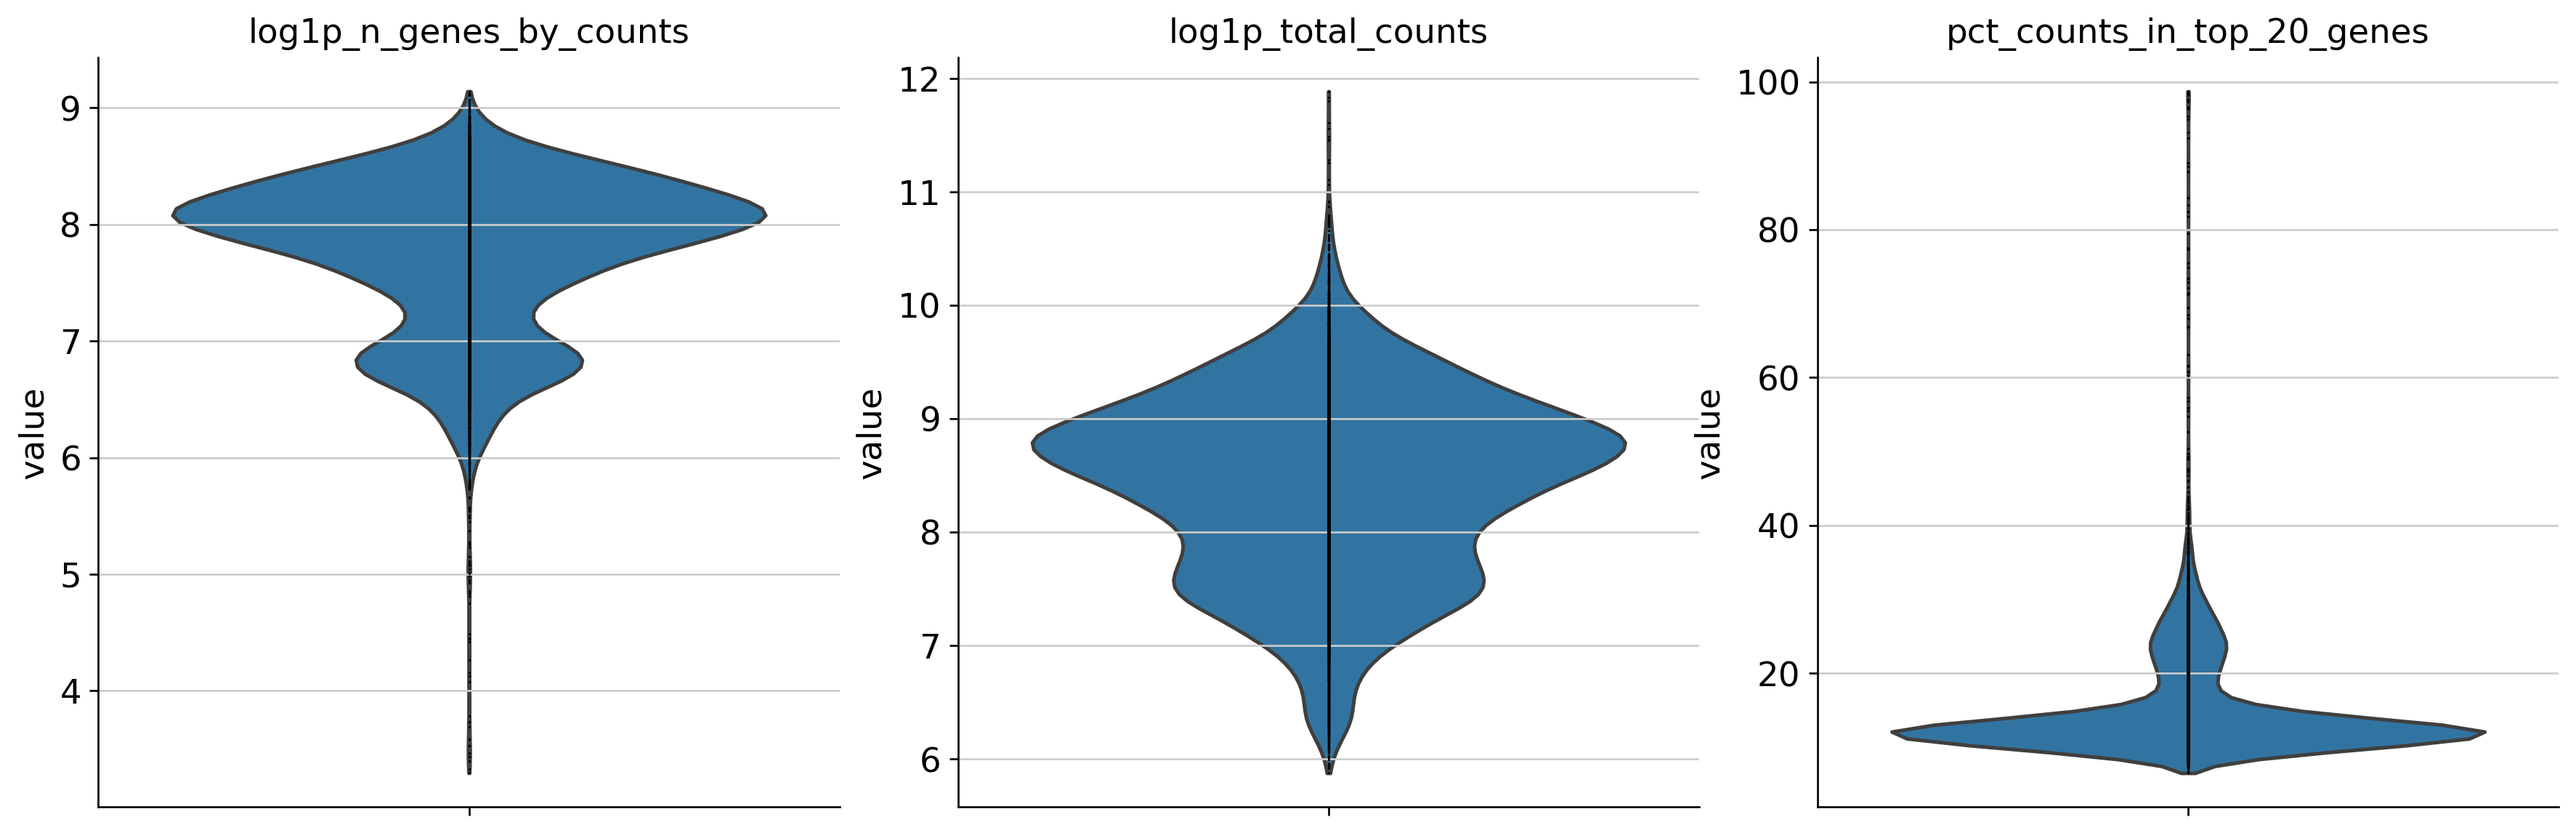

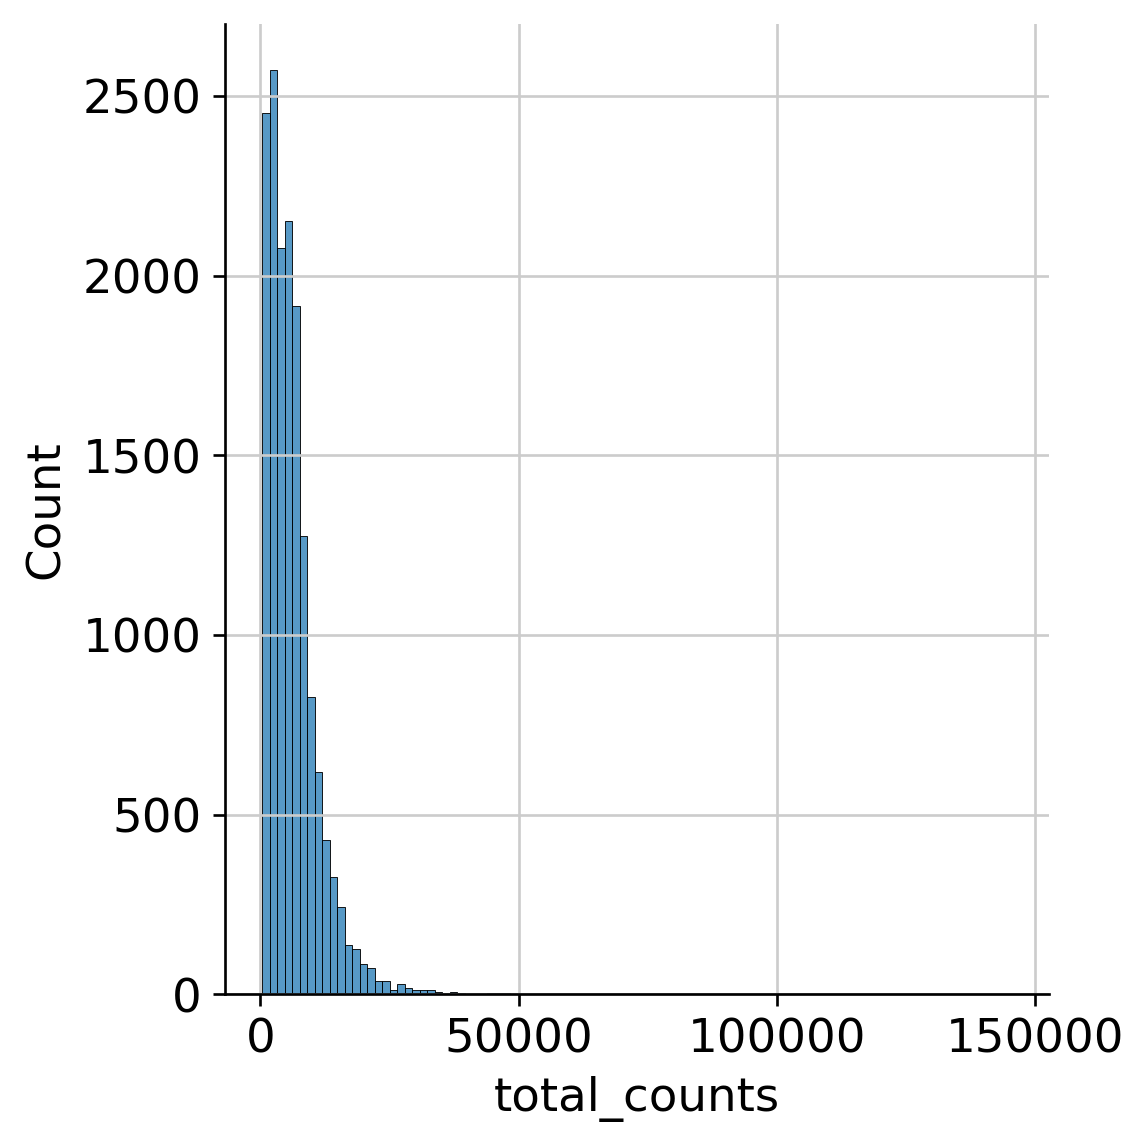

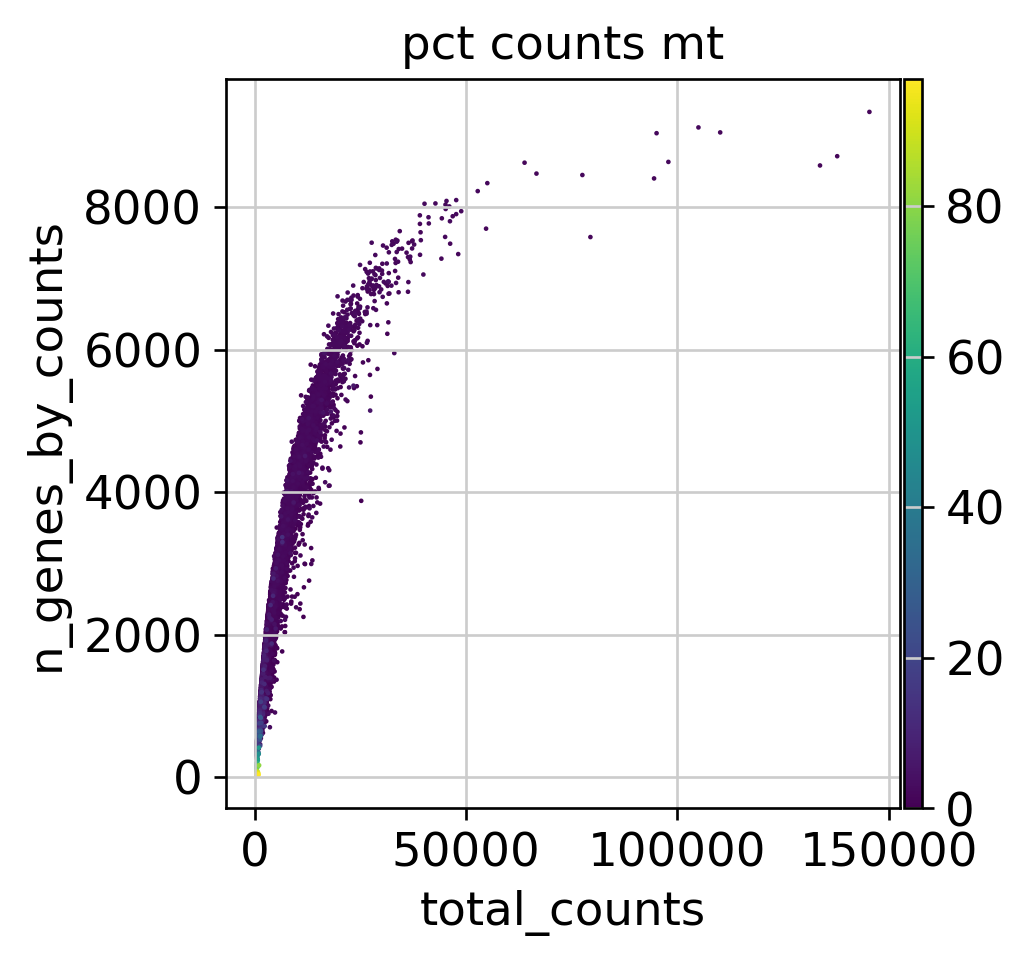

--------------------------------------------------
 CHR0406 doublet ver 1 QC plot top


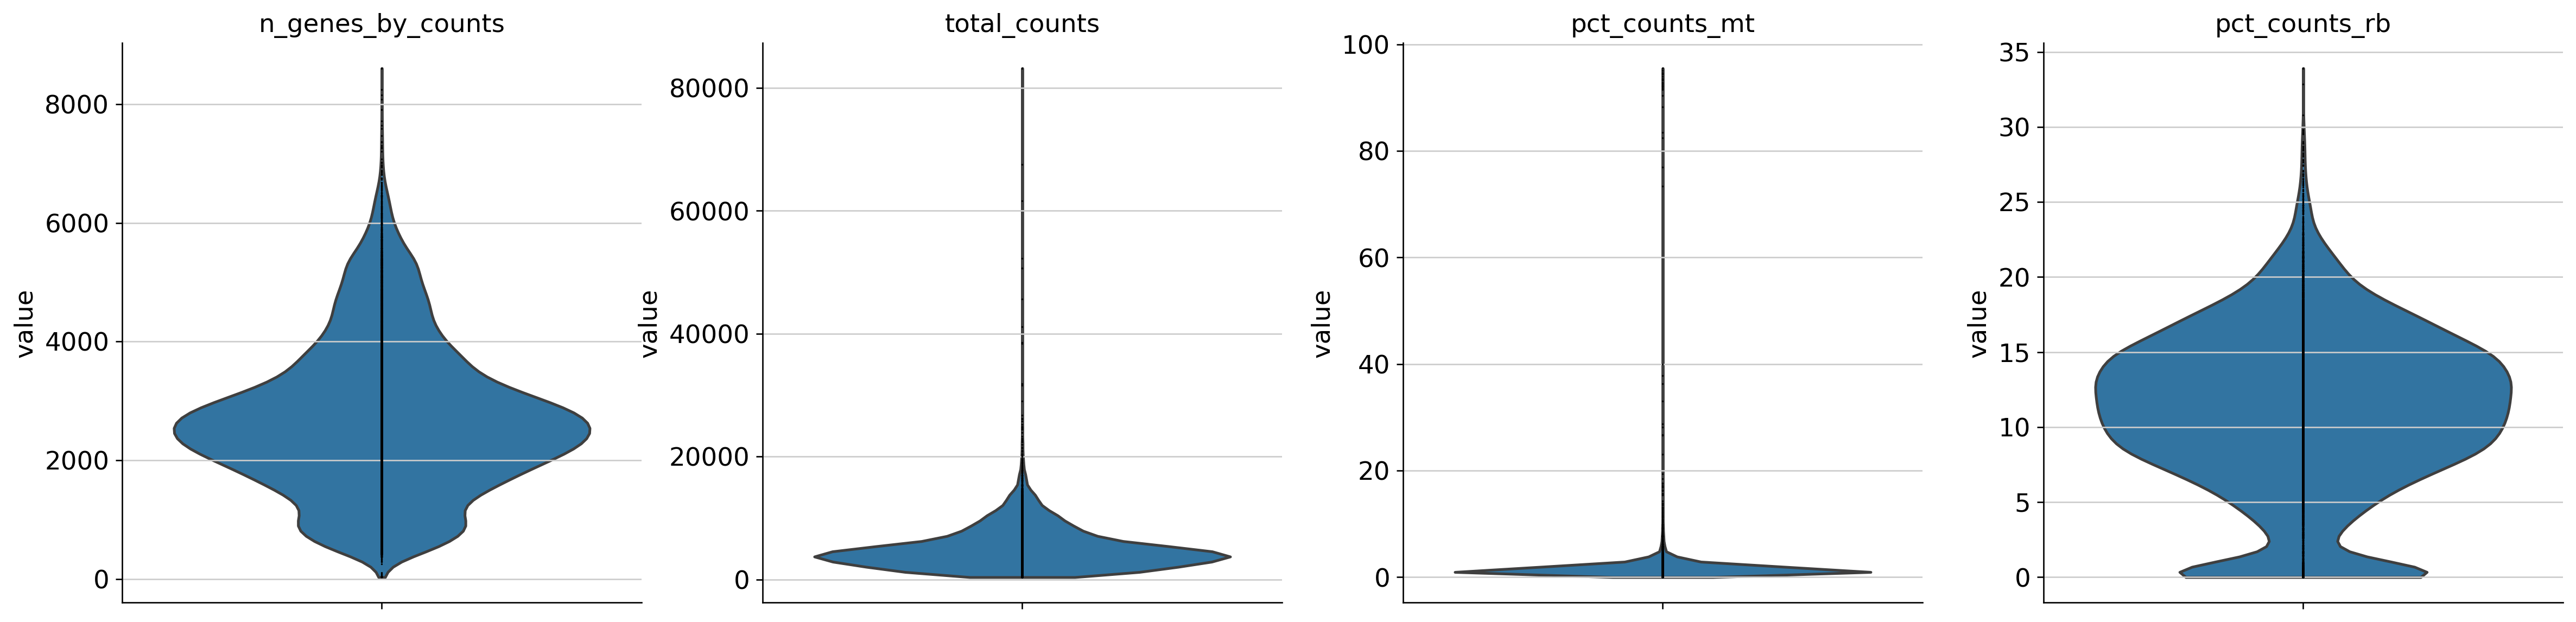

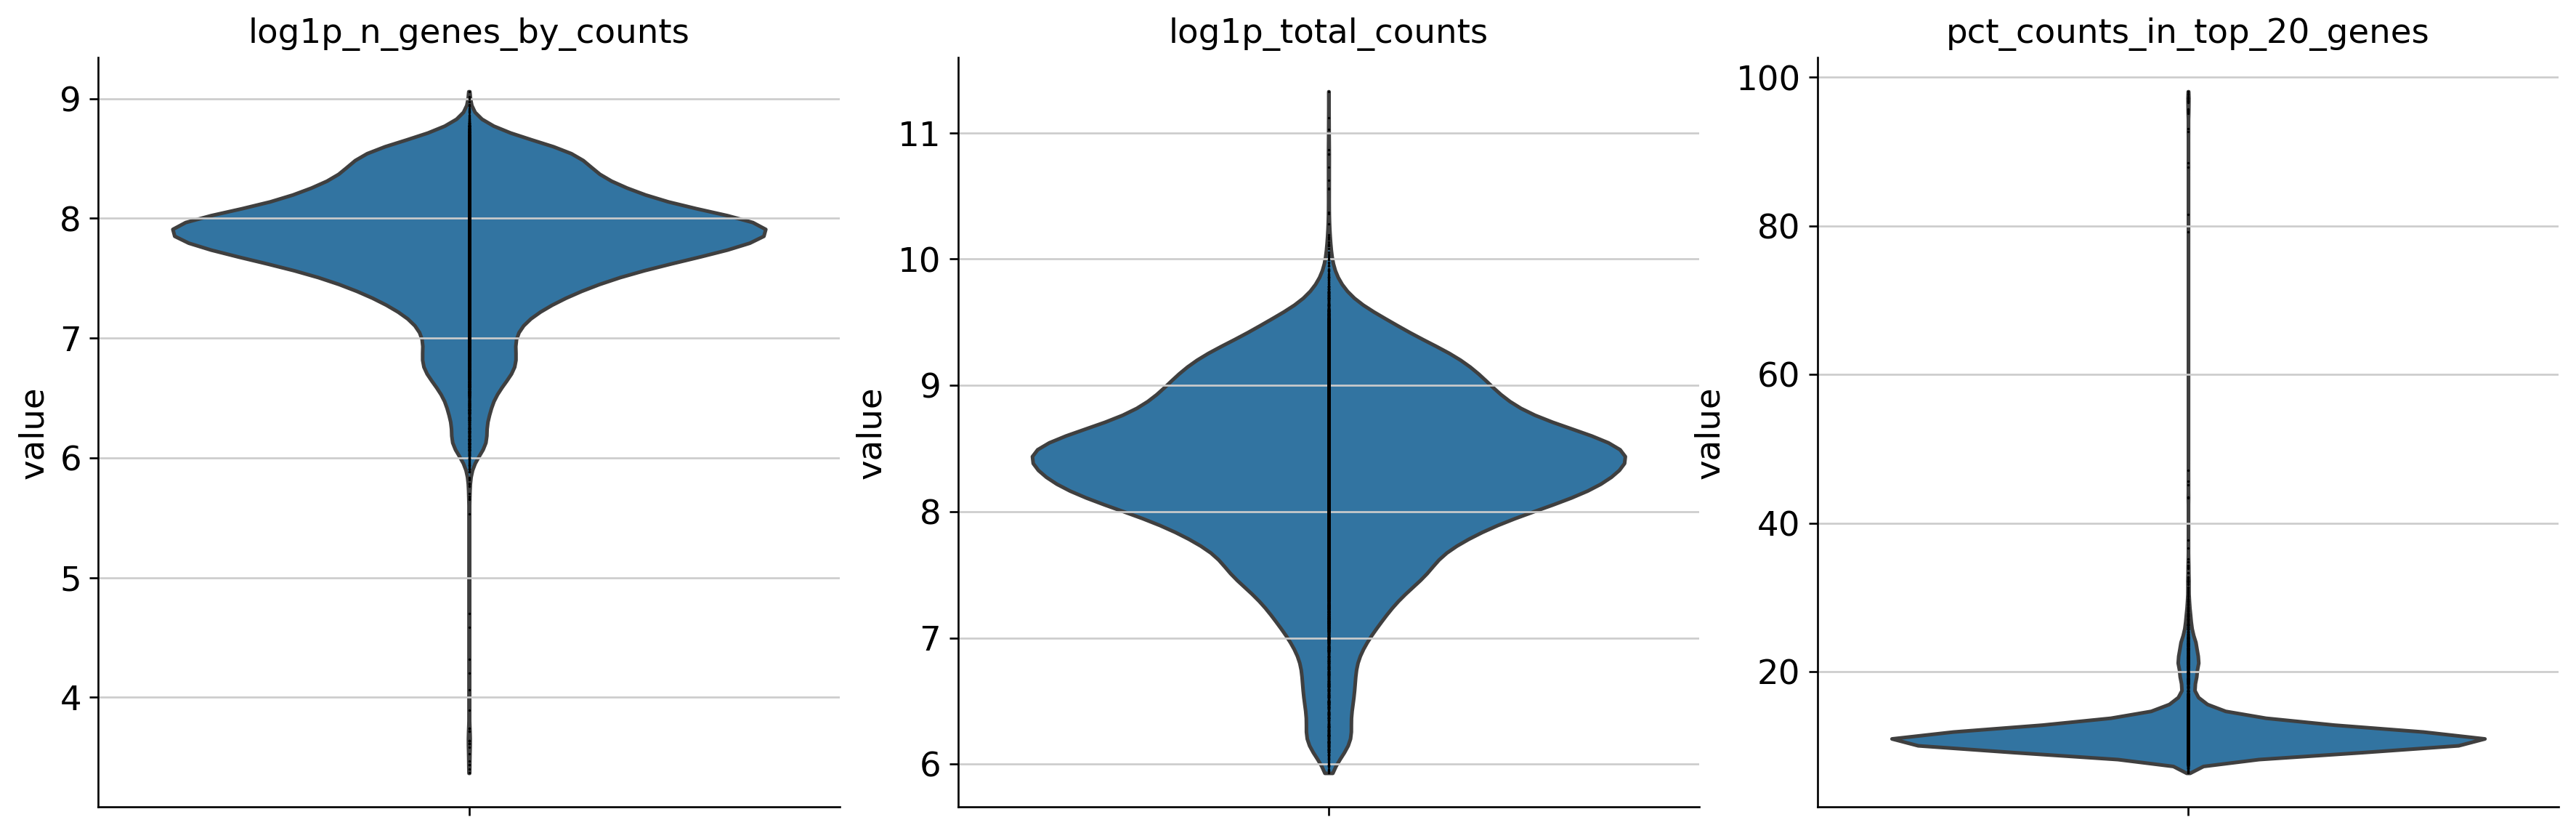

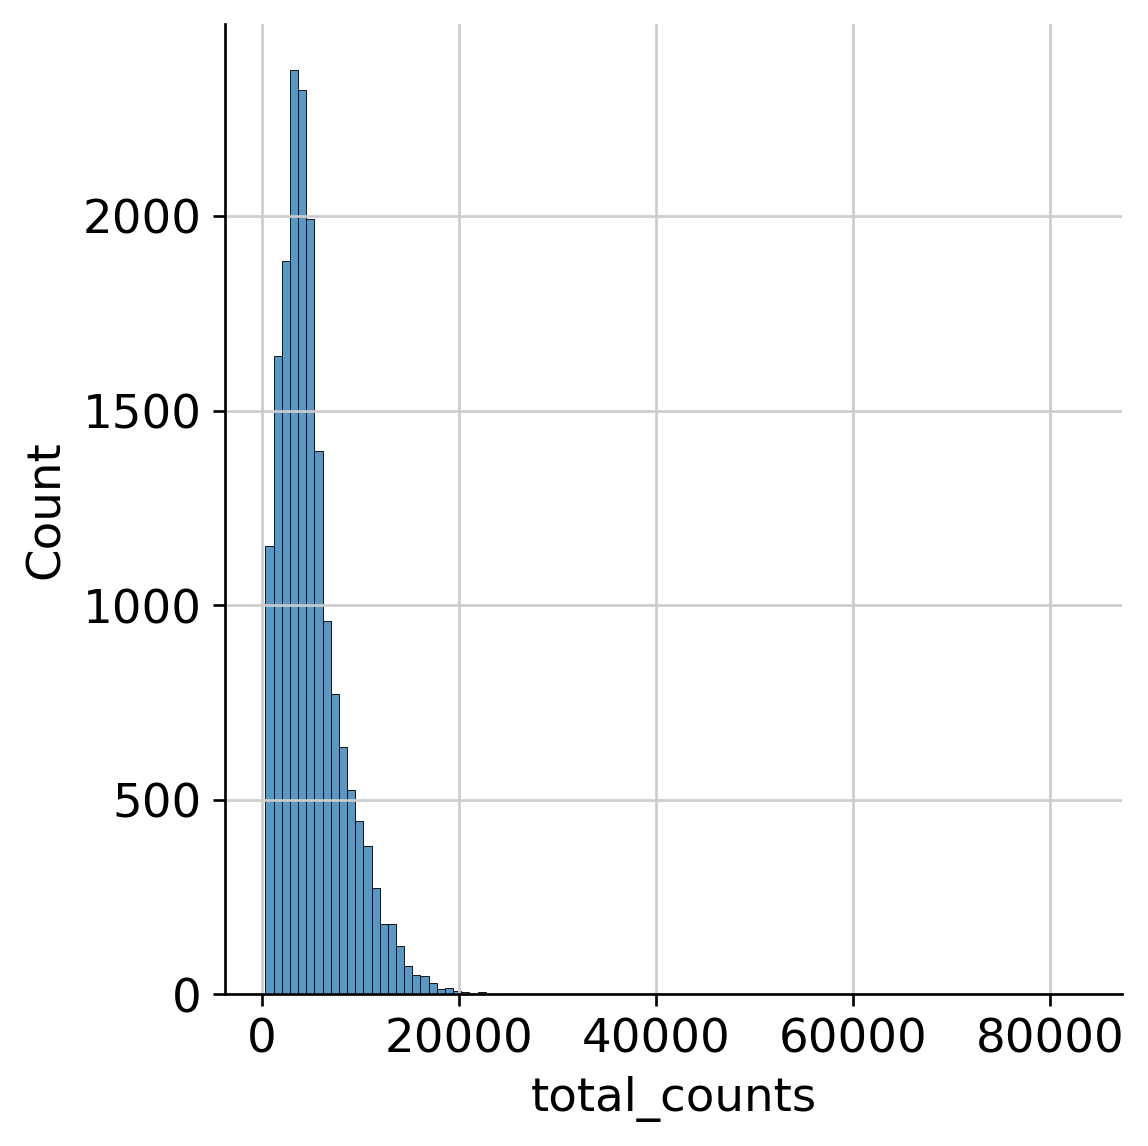

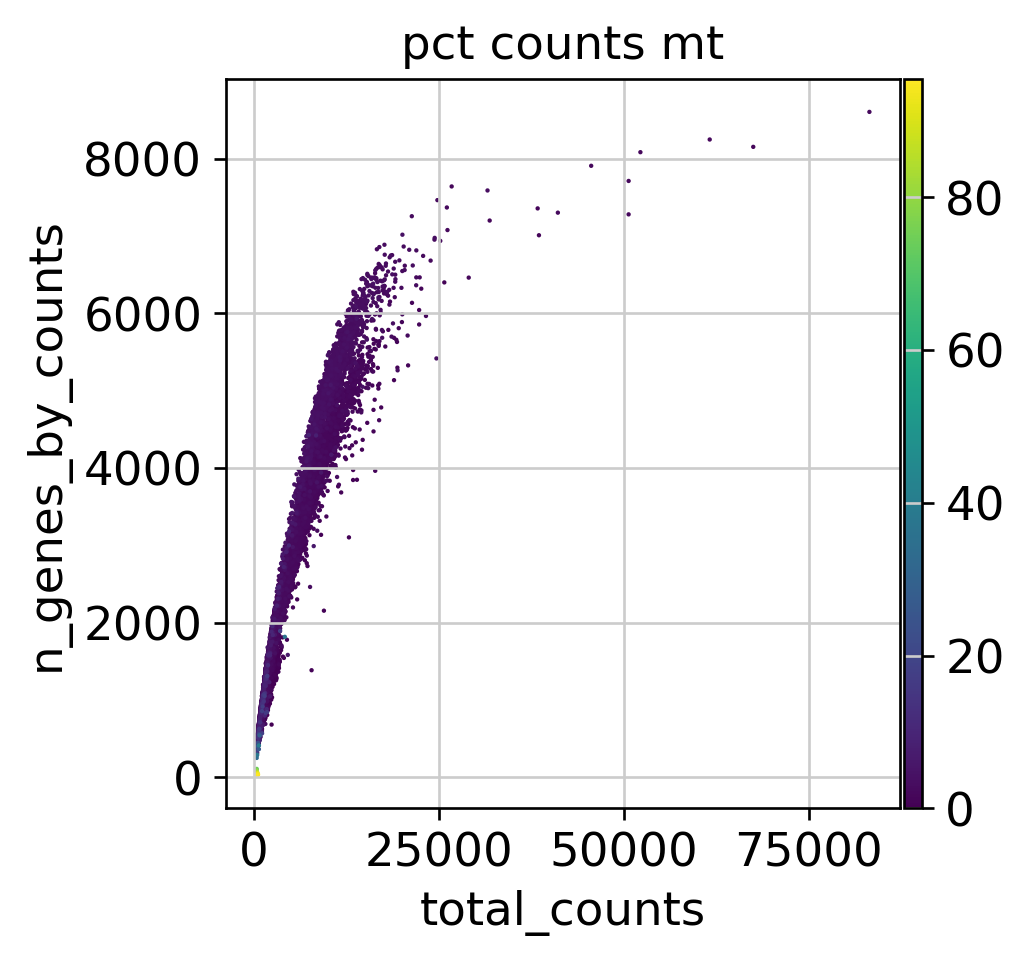

--------------------------------------------------
 CHR0407 doublet ver 1 QC plot top


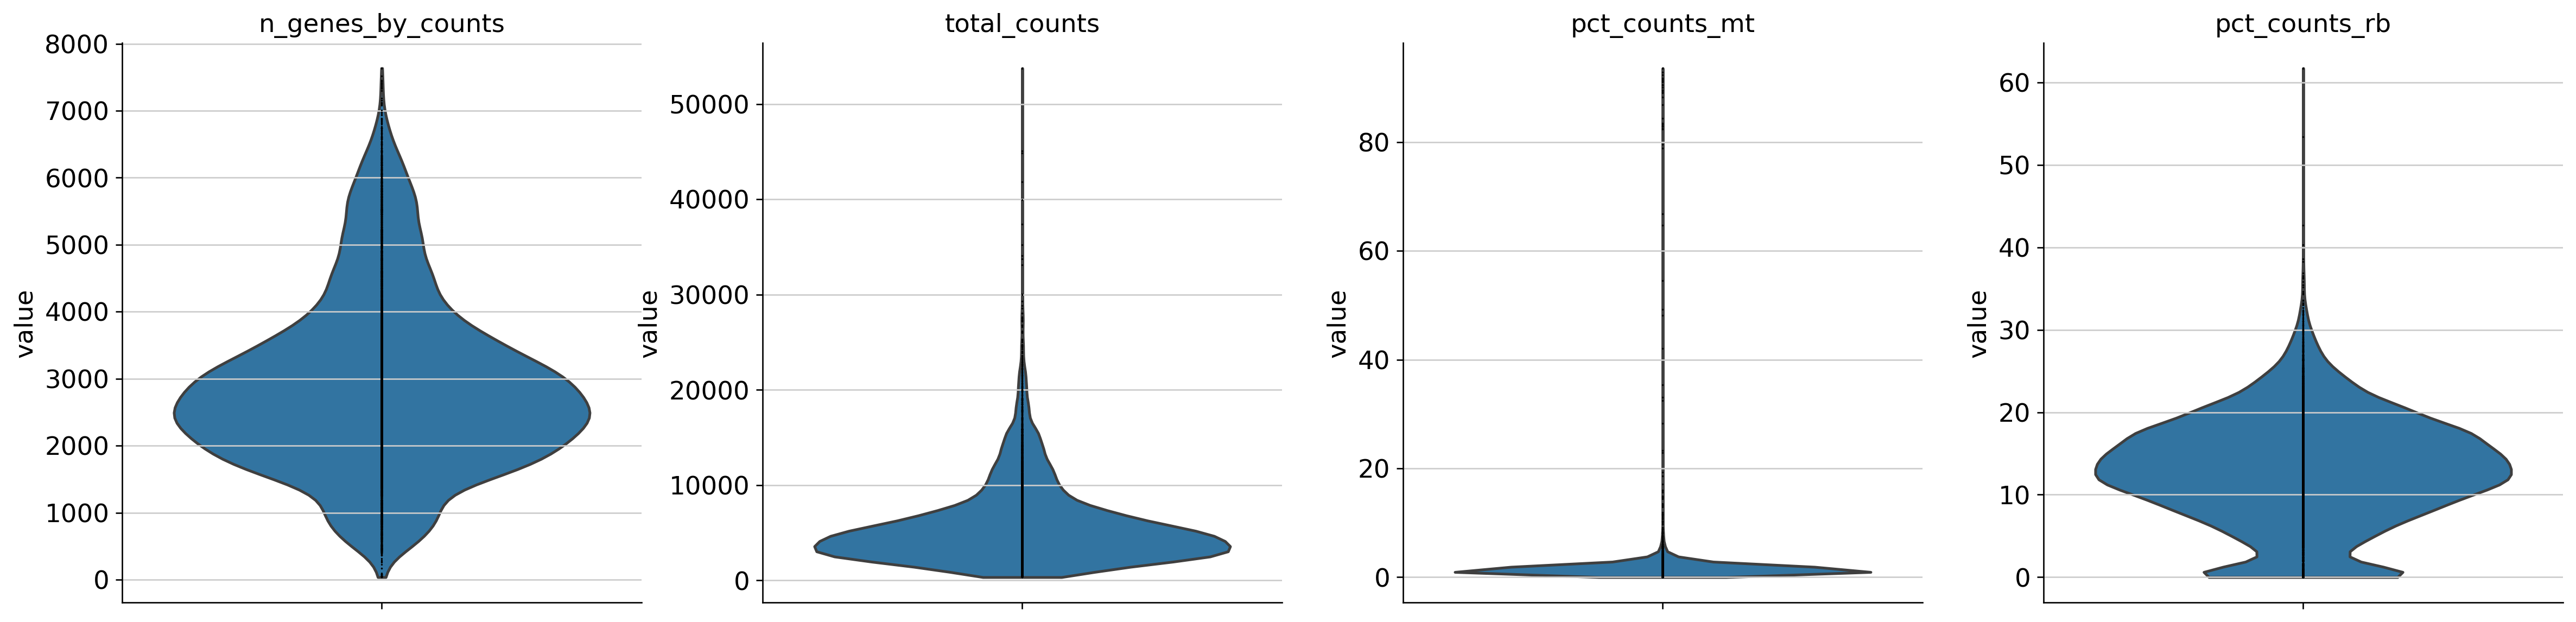

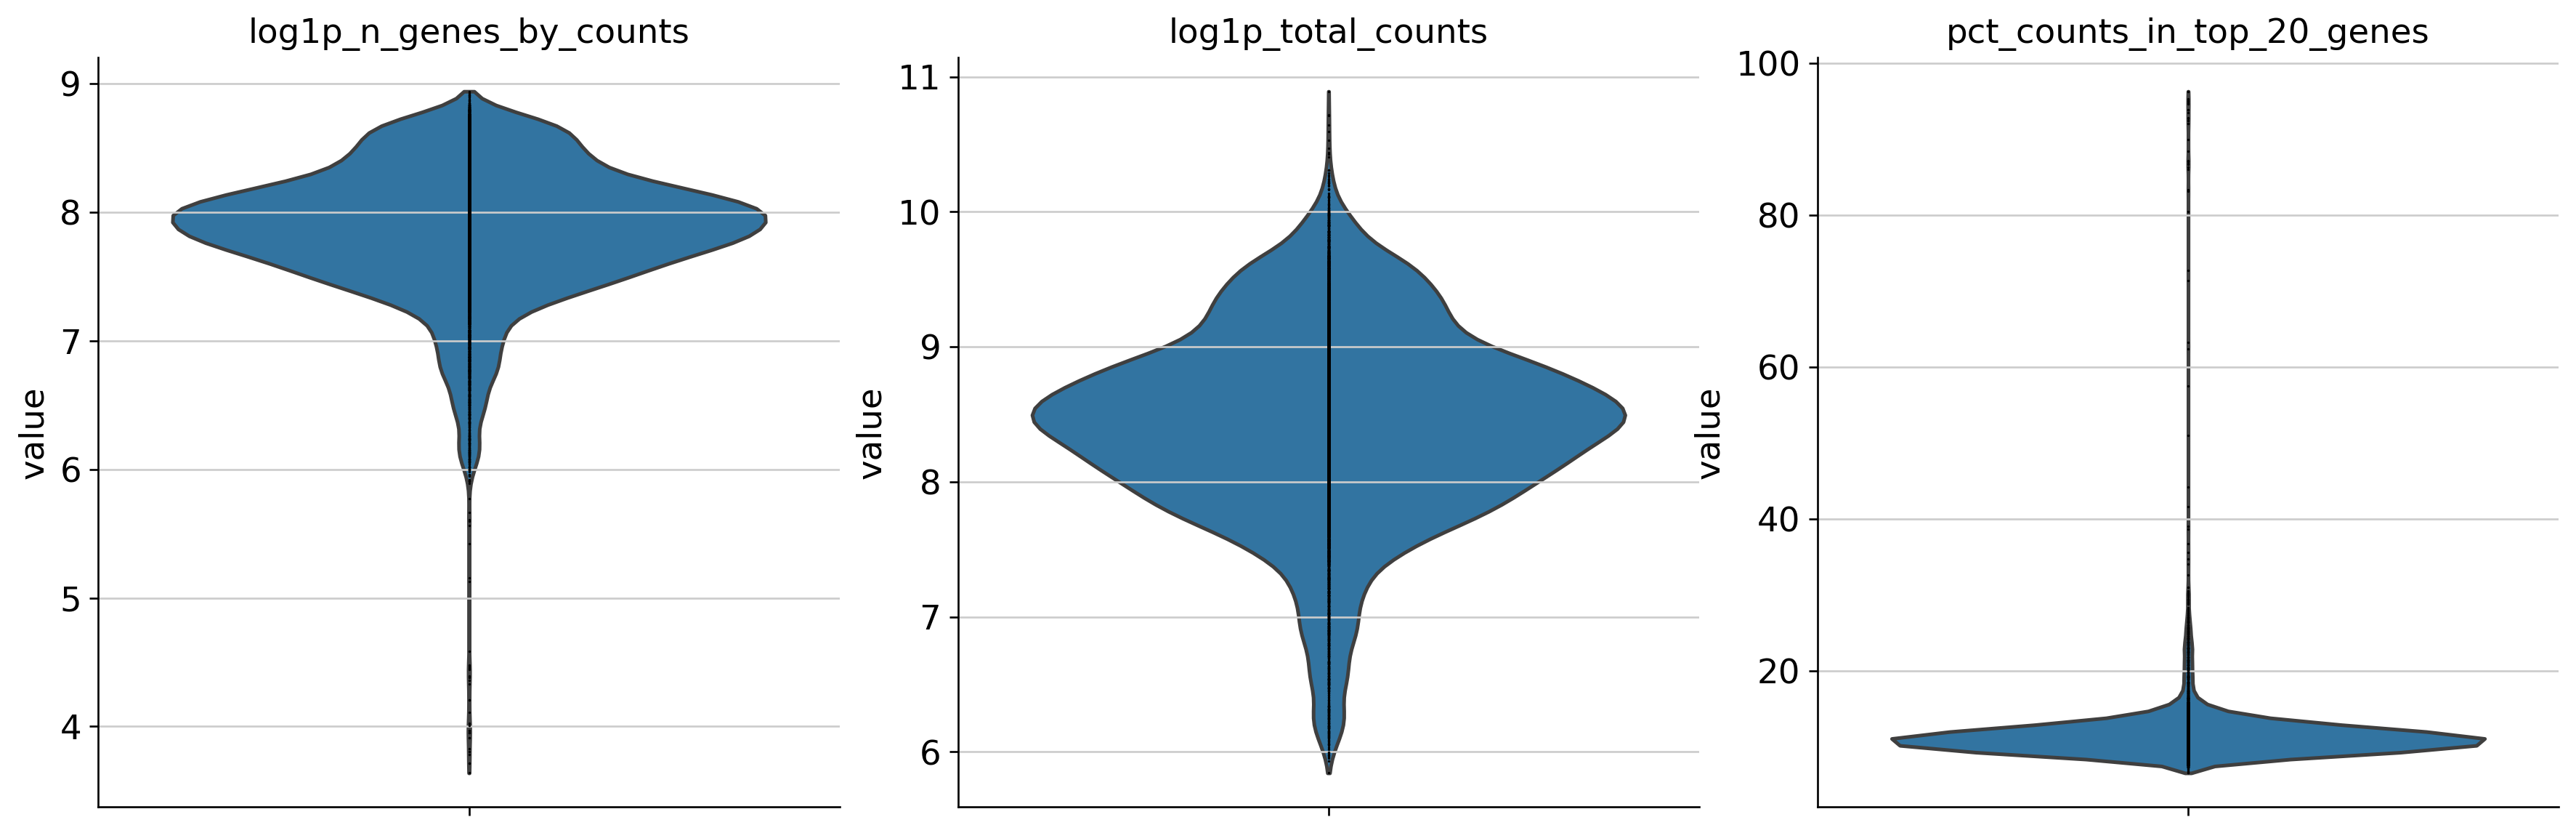

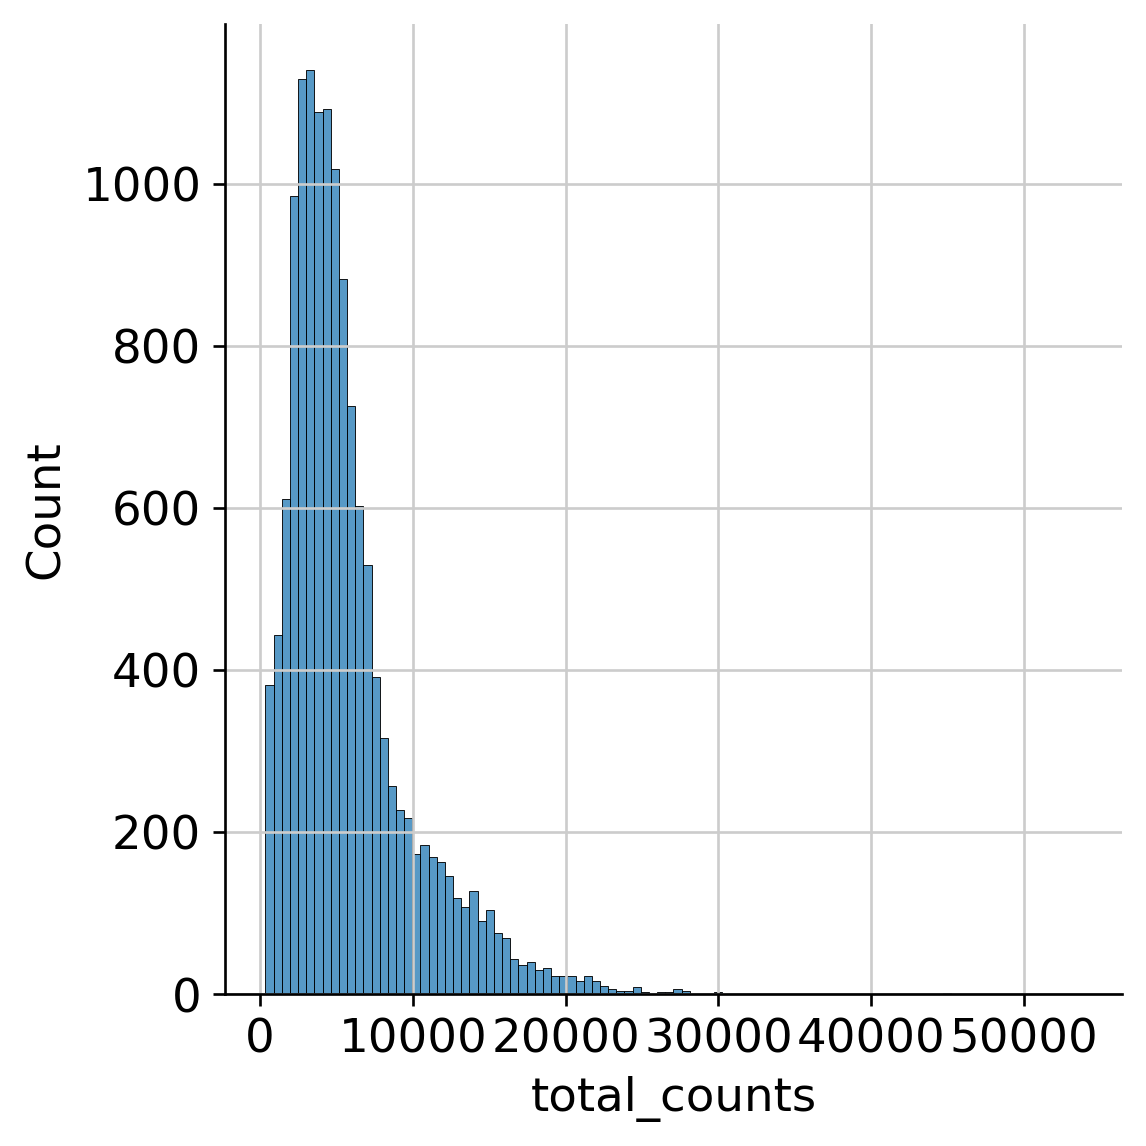

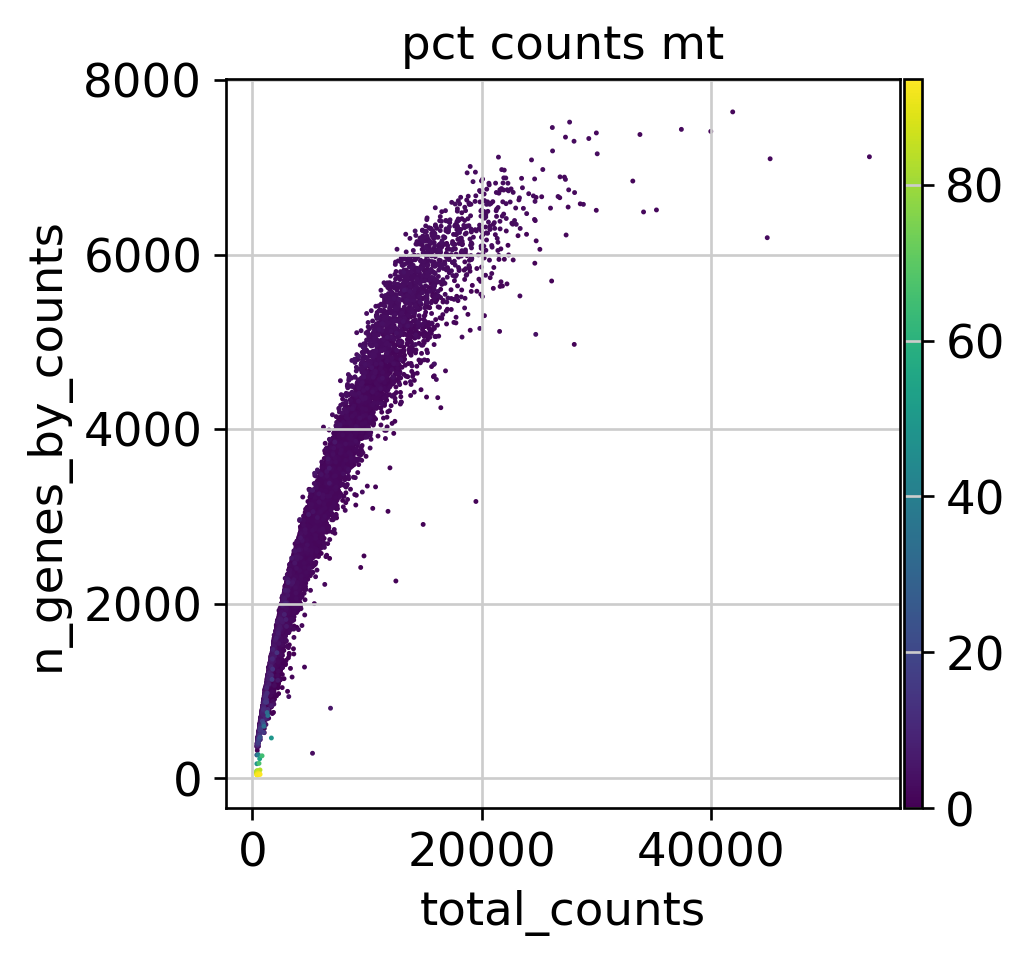

--------------------------------------------------


In [9]:
## make QC column and plotting
for i in range(0, len(sample)) :
    print('=' * 50)
    data1[i].var['mt'] = data1[i].var_names.str.startswith('mt-') ## mitochondrial genes
    data1[i].var['rb'] = data1[i].var.index.str.contains('^Rp[sl]') ## ribosomal genes
    sc.pp.calculate_qc_metrics(data1[i], qc_vars = ['mt', 'rb'], percent_top = [20], log1p = True, inplace = True)
    
    print(f' {sample[i]} doublet ver 1 QC plot top')
    sc.pl.violin(data1[i], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rb'], jitter = 0, multi_panel = True)
    sc.pl.violin(data1[i], ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes'], jitter = 0, multi_panel = True)
    sns.displot(data1[i].obs["total_counts"], bins = 100, kde = False)
    sc.pl.scatter(data1[i], "total_counts", "n_genes_by_counts", color = "pct_counts_mt")
    
    print('-' * 50)

In [10]:
## save files (add QC verision)
for i in range(0, len(sample)) :    
    data1[i].write(path2 + sample[i] + '.scAR.solo1.qc.h5ad')

### 4-1. MAD filtering 

In [5]:
## Read raw files
data1 = []

for i in range(0, len(sample)) :
    data1.append(sc.read_h5ad(path2 + sample[i] + '.scAR.solo1.qc.h5ad'))

In [6]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [7]:
for i in range(0, len(sample)) :
    print('=' * 50)
    data1[i].obs["outlier"] = (is_outlier(data1[i], "log1p_total_counts", 5) 
                            | is_outlier(data1[i], "log1p_n_genes_by_counts", 5)
                            | is_outlier(data1[i], "pct_counts_in_top_20_genes", 5)
                            | (data1[i].obs["n_genes_by_counts"] > 7000) 
                            | (data1[i].obs["n_genes_by_counts"] < 200)
                            | (data1[i].obs["total_counts"] > 20000)
                            | (data1[i].obs["total_counts"] < 1000)
                              )
    print(f' {sample[i]} ver1 {data1[i].obs.outlier.value_counts()}')
    print('-' * 50)

 CHR0405 ver1 False    12441
True      3097
Name: outlier, dtype: int64
--------------------------------------------------
 CHR0406 ver1 False    15704
True      1826
Name: outlier, dtype: int64
--------------------------------------------------
 CHR0407 ver1 False    12930
True      1009
Name: outlier, dtype: int64
--------------------------------------------------


In [8]:
for i in range(0, len(sample)) :
    print('=' * 50)
    data1[i].obs["mt_outlier"] = (is_outlier(data1[i], "pct_counts_mt", 3)
                            | (data1[i].obs["pct_counts_mt"] > 10))
    print(f' {sample[i]} ver1 {data1[i].obs.mt_outlier.value_counts()}')
    print('-' * 50)

 CHR0405 ver1 False    14170
True      1368
Name: mt_outlier, dtype: int64
--------------------------------------------------
 CHR0406 ver1 False    14264
True      3266
Name: mt_outlier, dtype: int64
--------------------------------------------------
 CHR0407 ver1 False    11794
True      2145
Name: mt_outlier, dtype: int64
--------------------------------------------------


 CHR0405 doublet ver 1 Total number of cells : 15538
 CHR0405 doublet ver 1 Number of cells after filtering of low quality cells : 11558


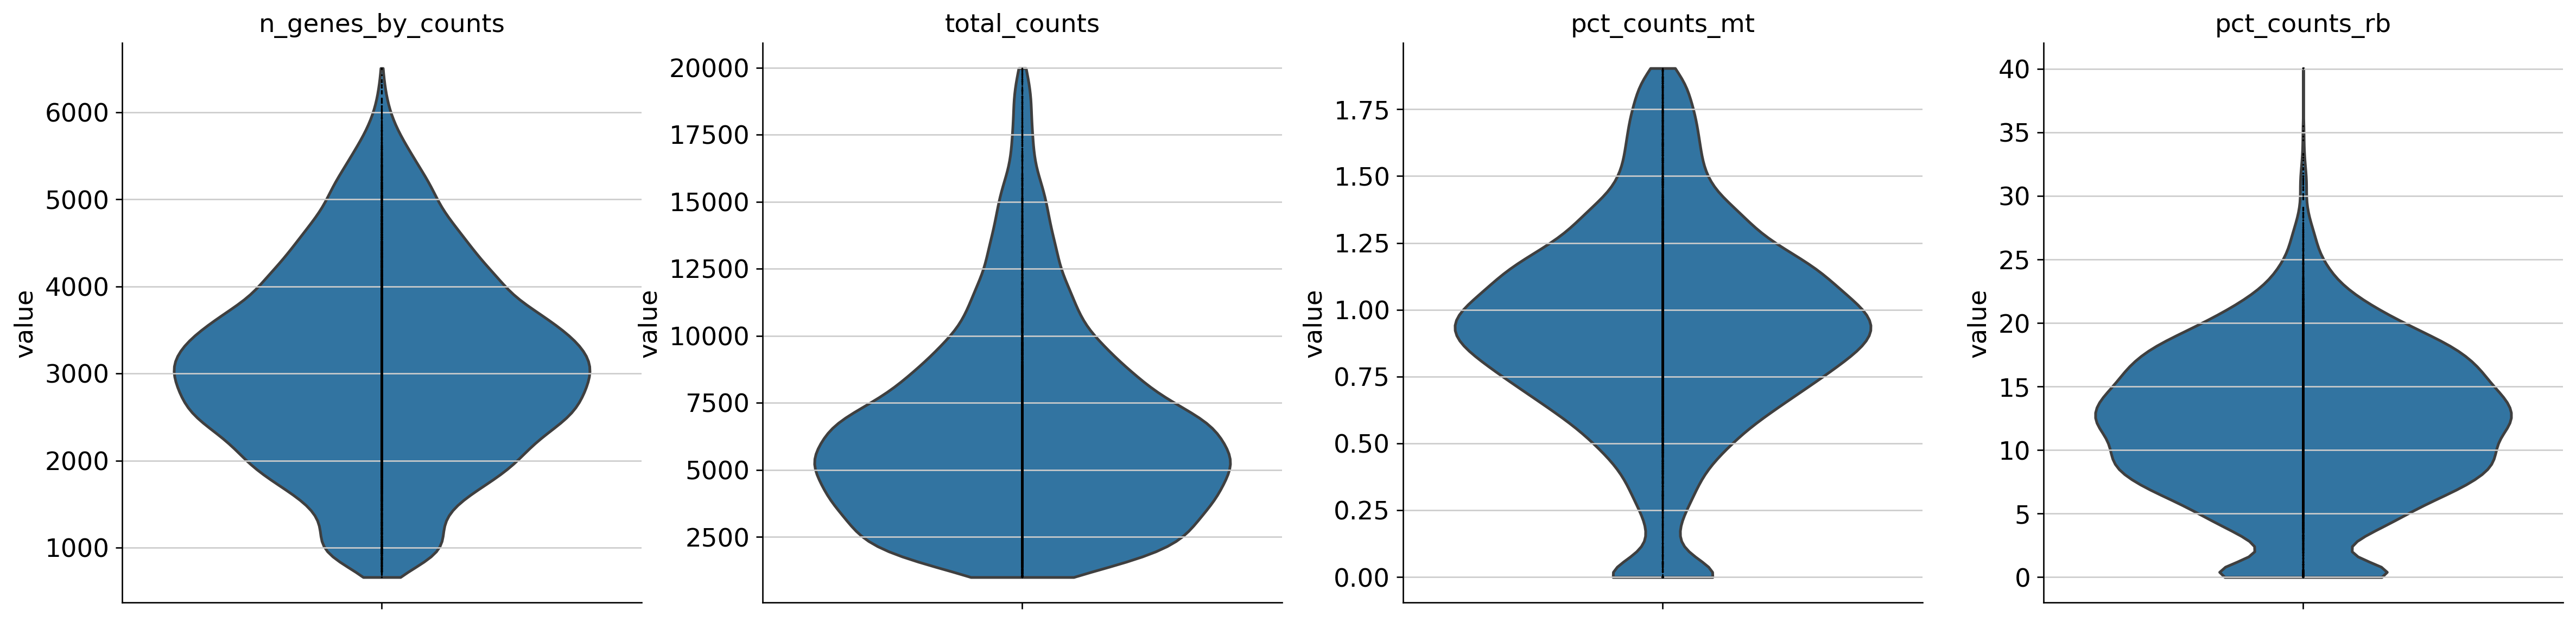

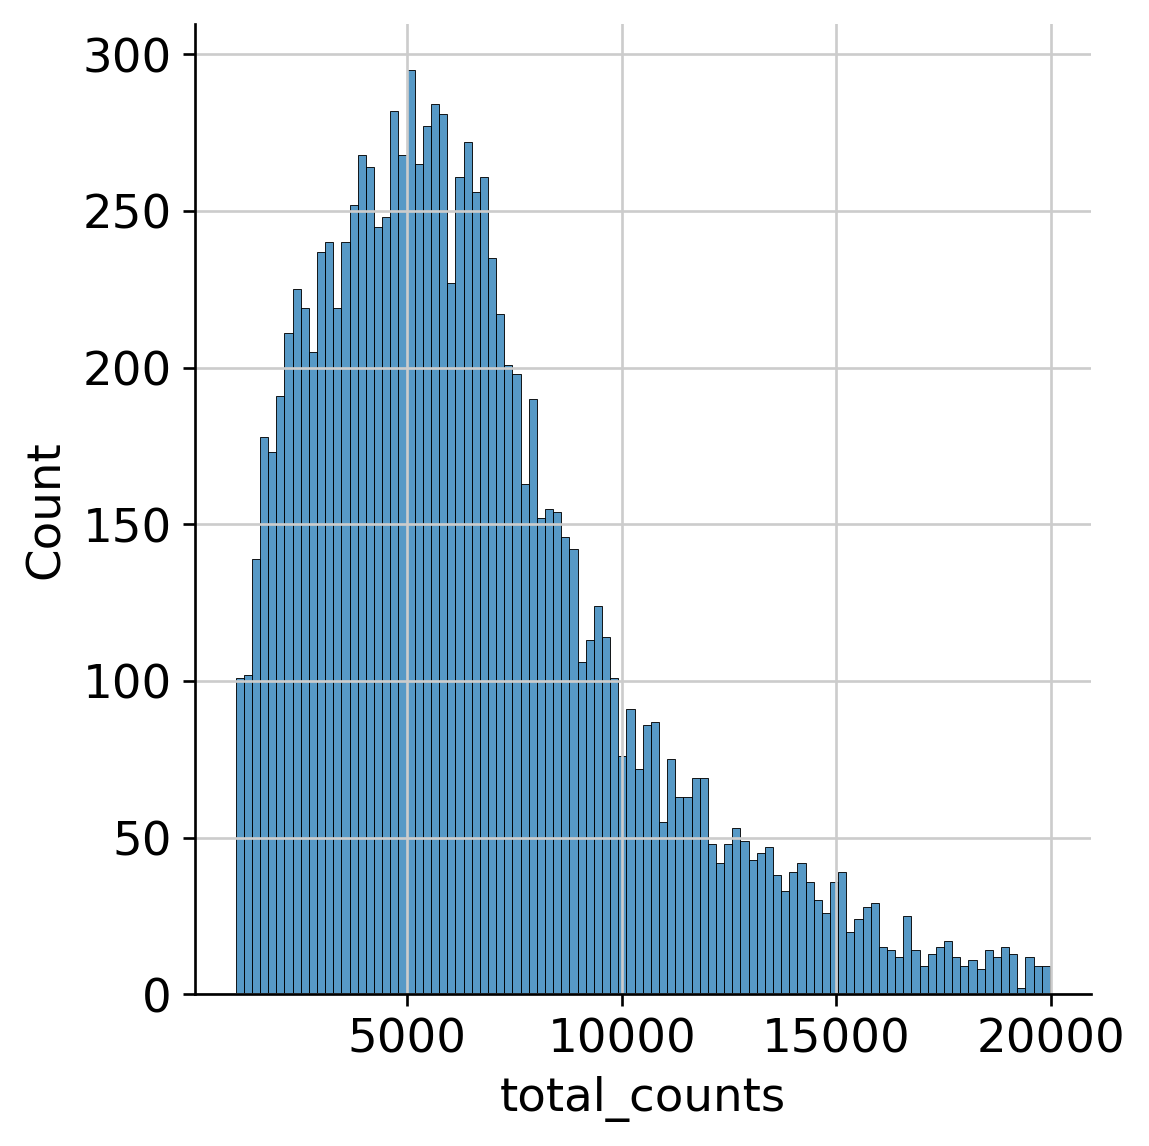

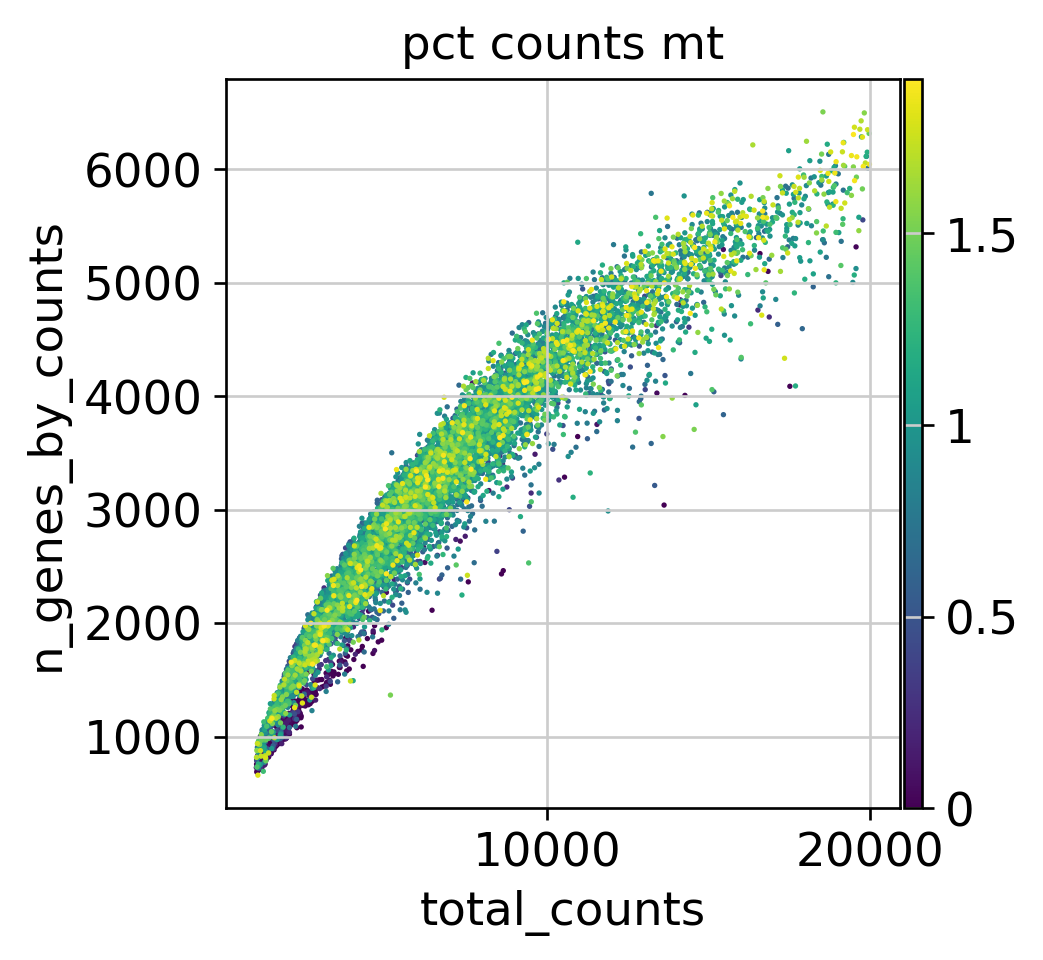

 CHR0406 doublet ver 1 Total number of cells : 17530
 CHR0406 doublet ver 1 Number of cells after filtering of low quality cells : 13600


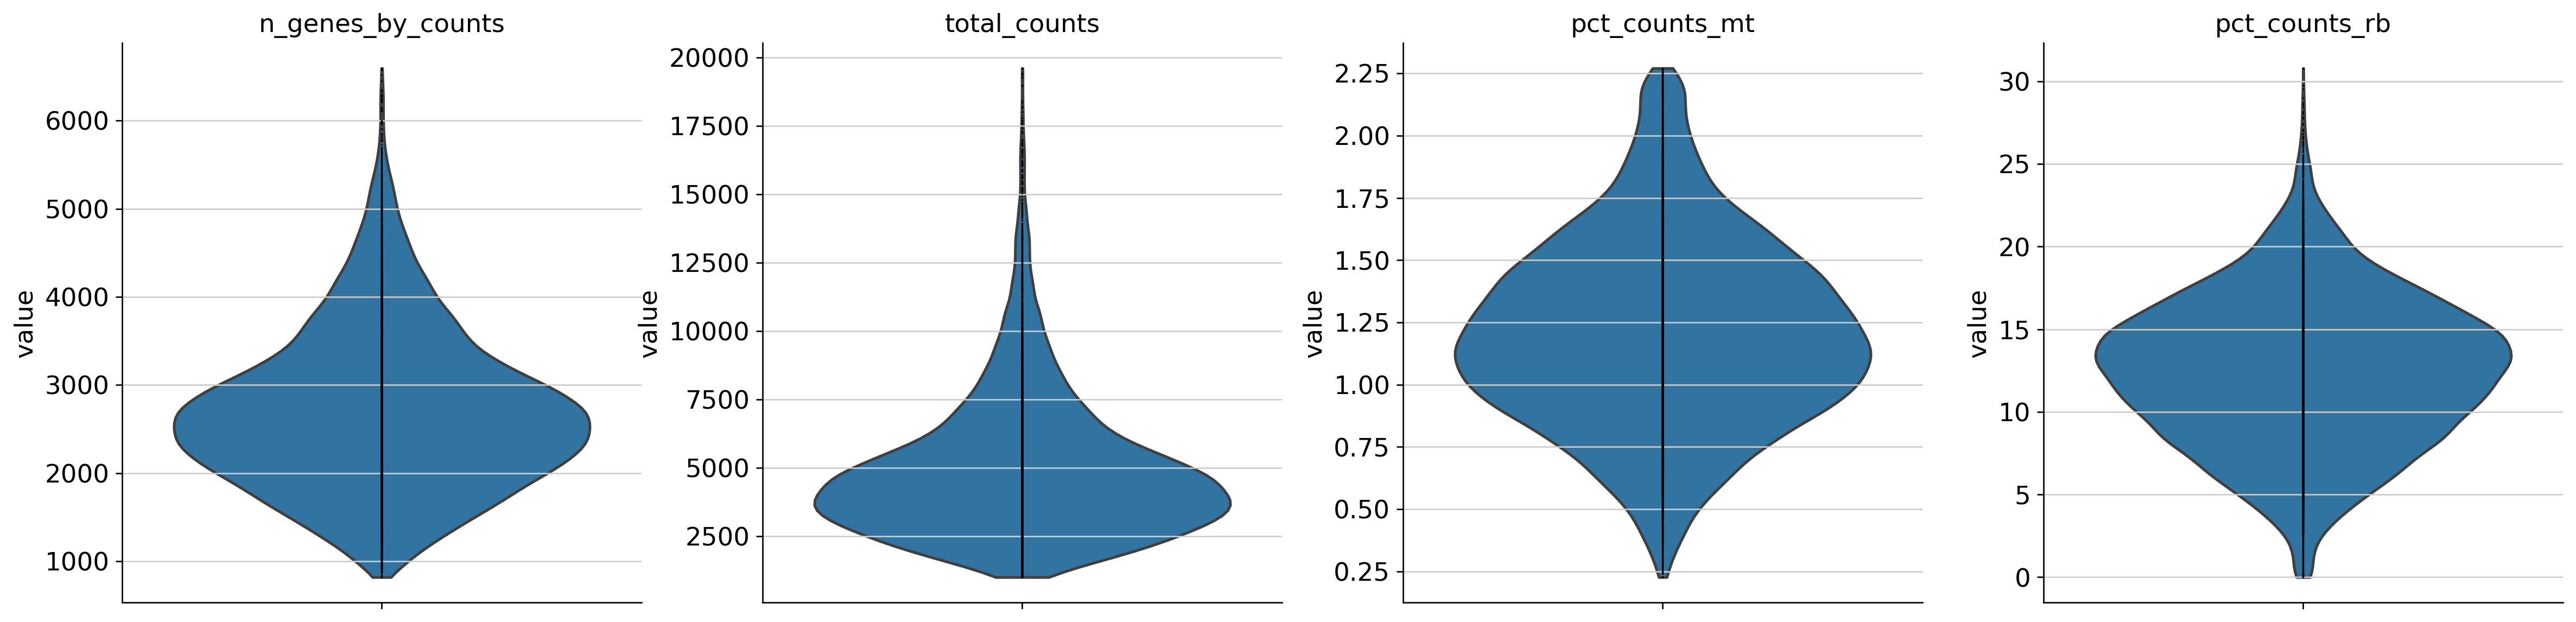

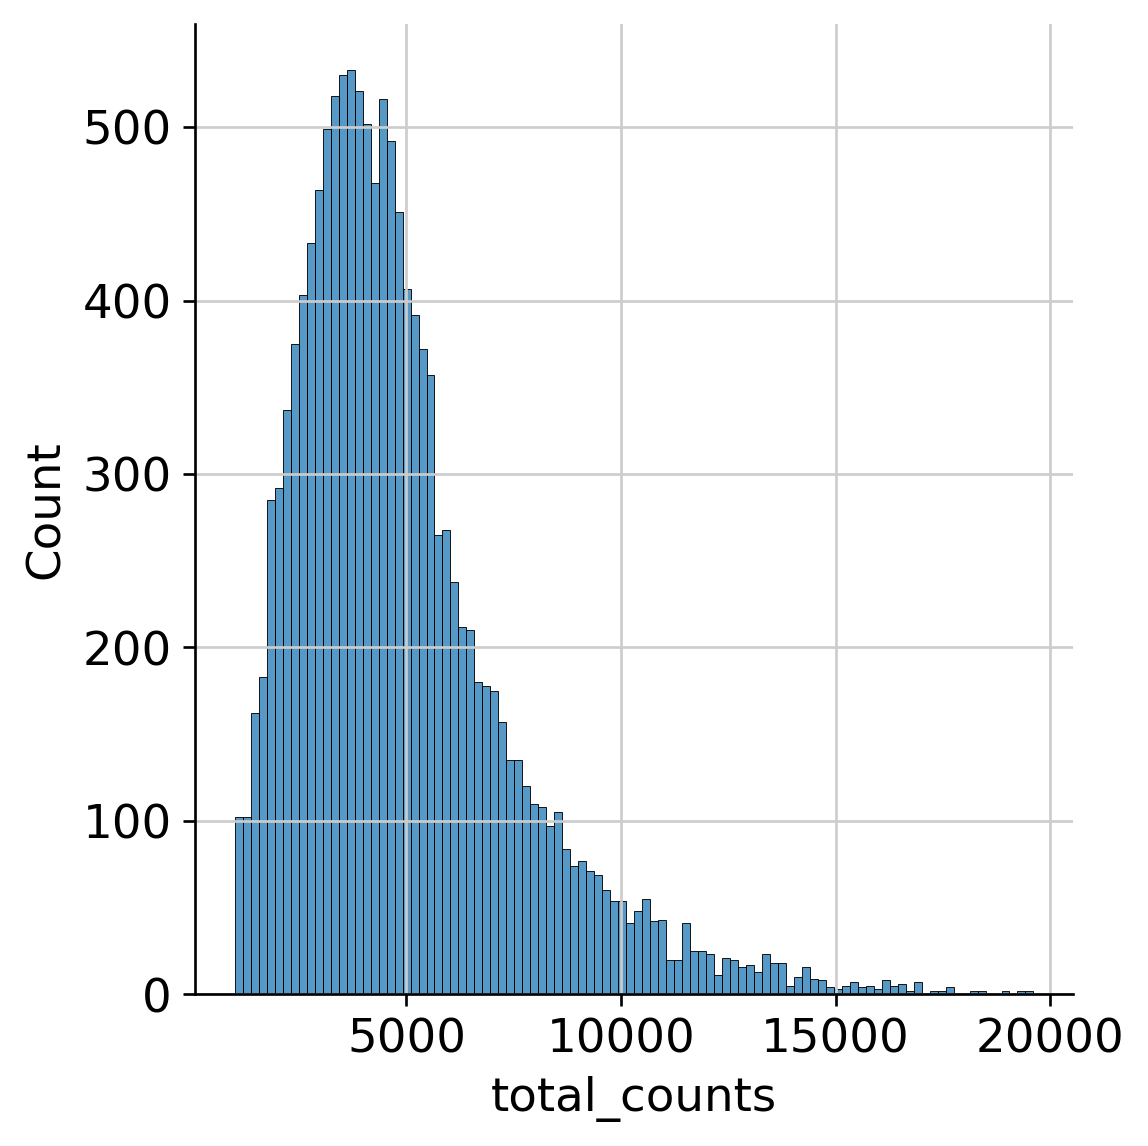

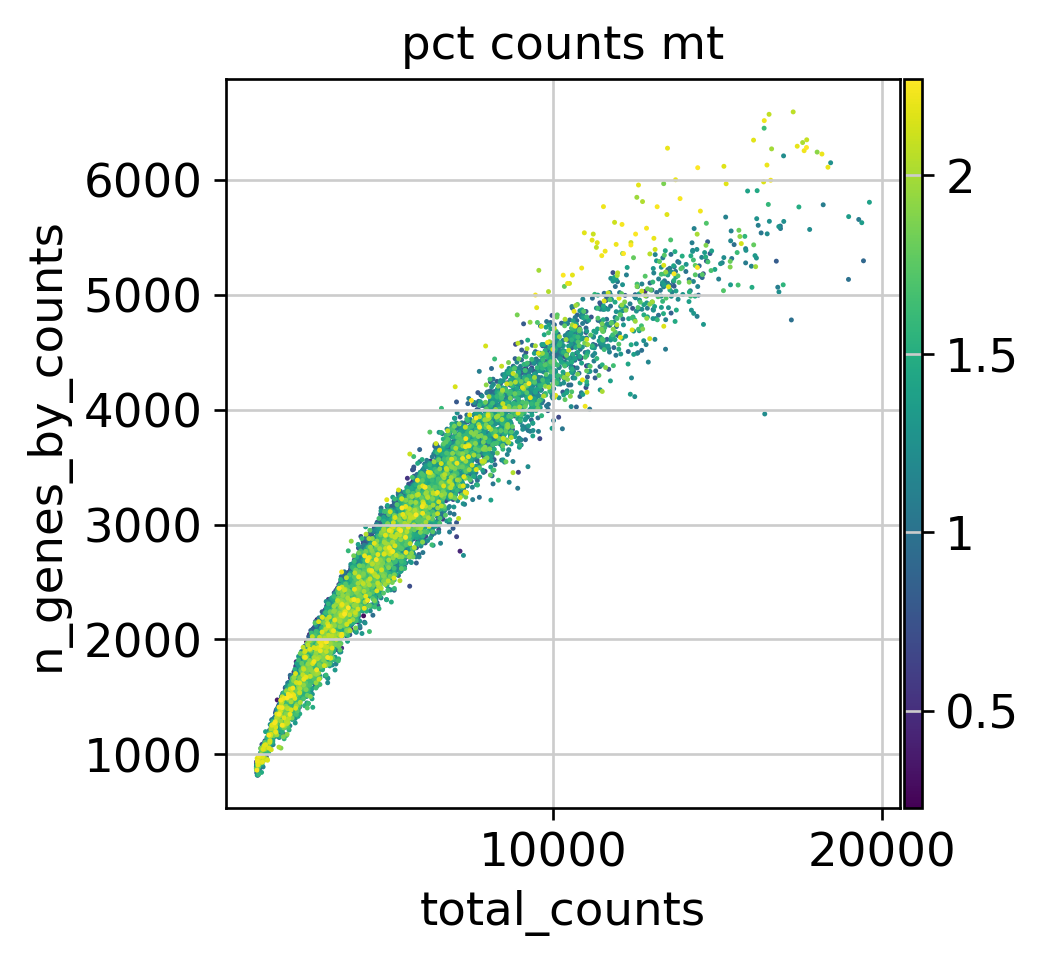

 CHR0407 doublet ver 1 Total number of cells : 13939
 CHR0407 doublet ver 1 Number of cells after filtering of low quality cells : 11391


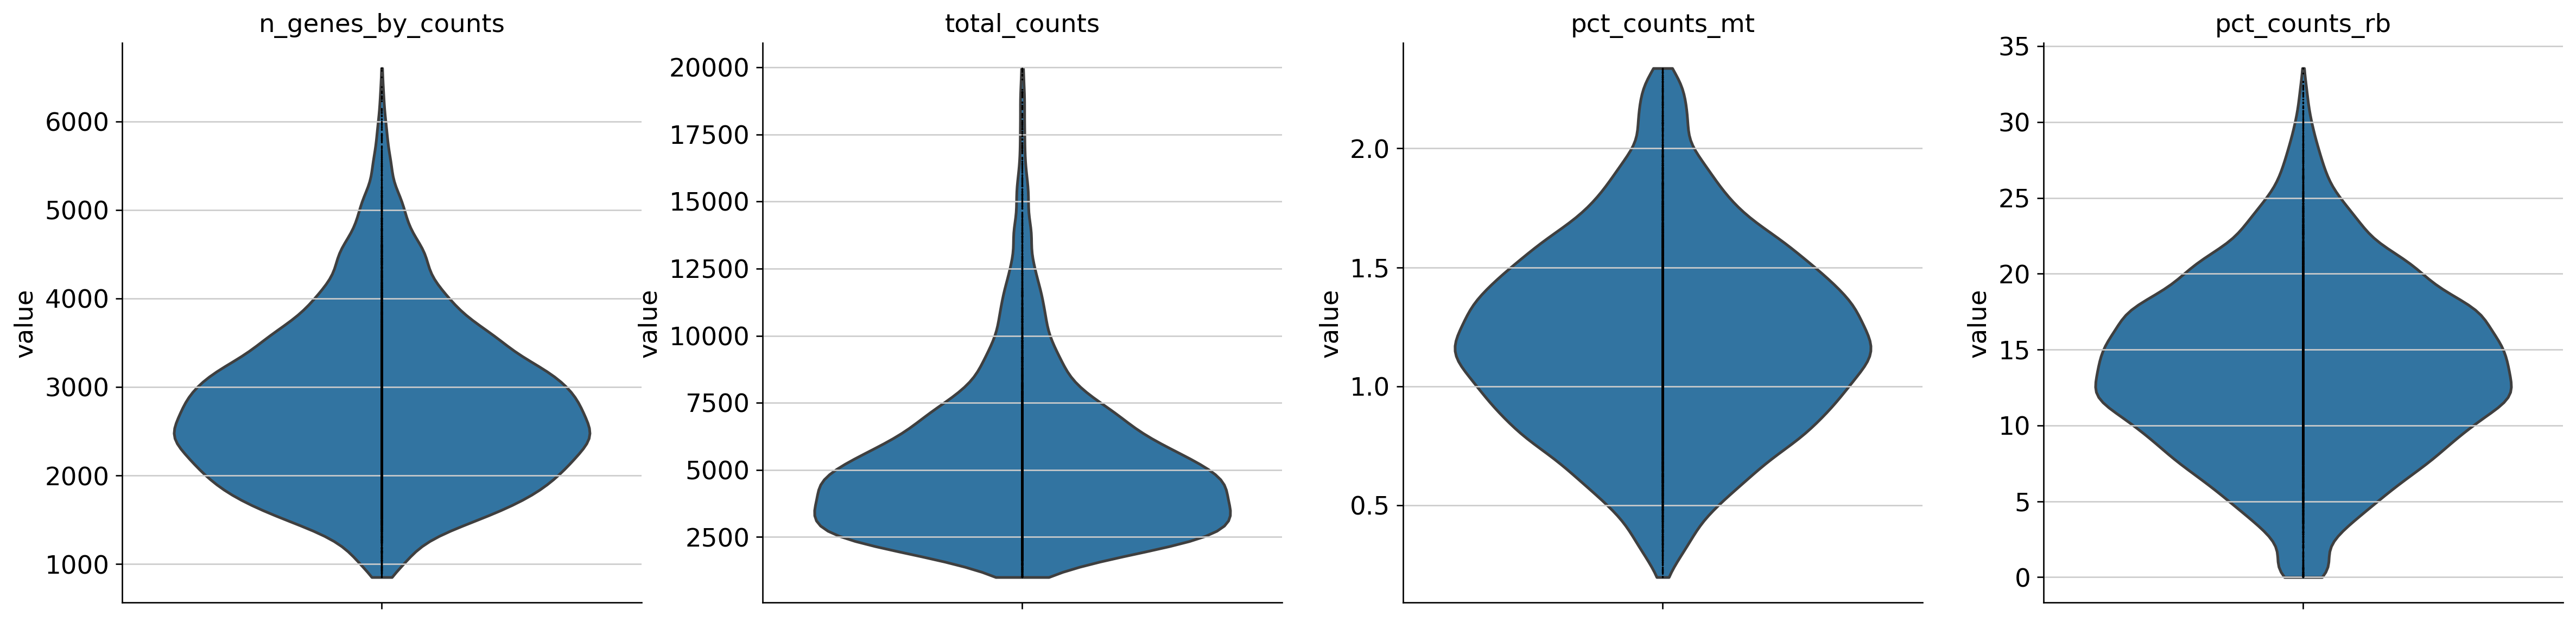

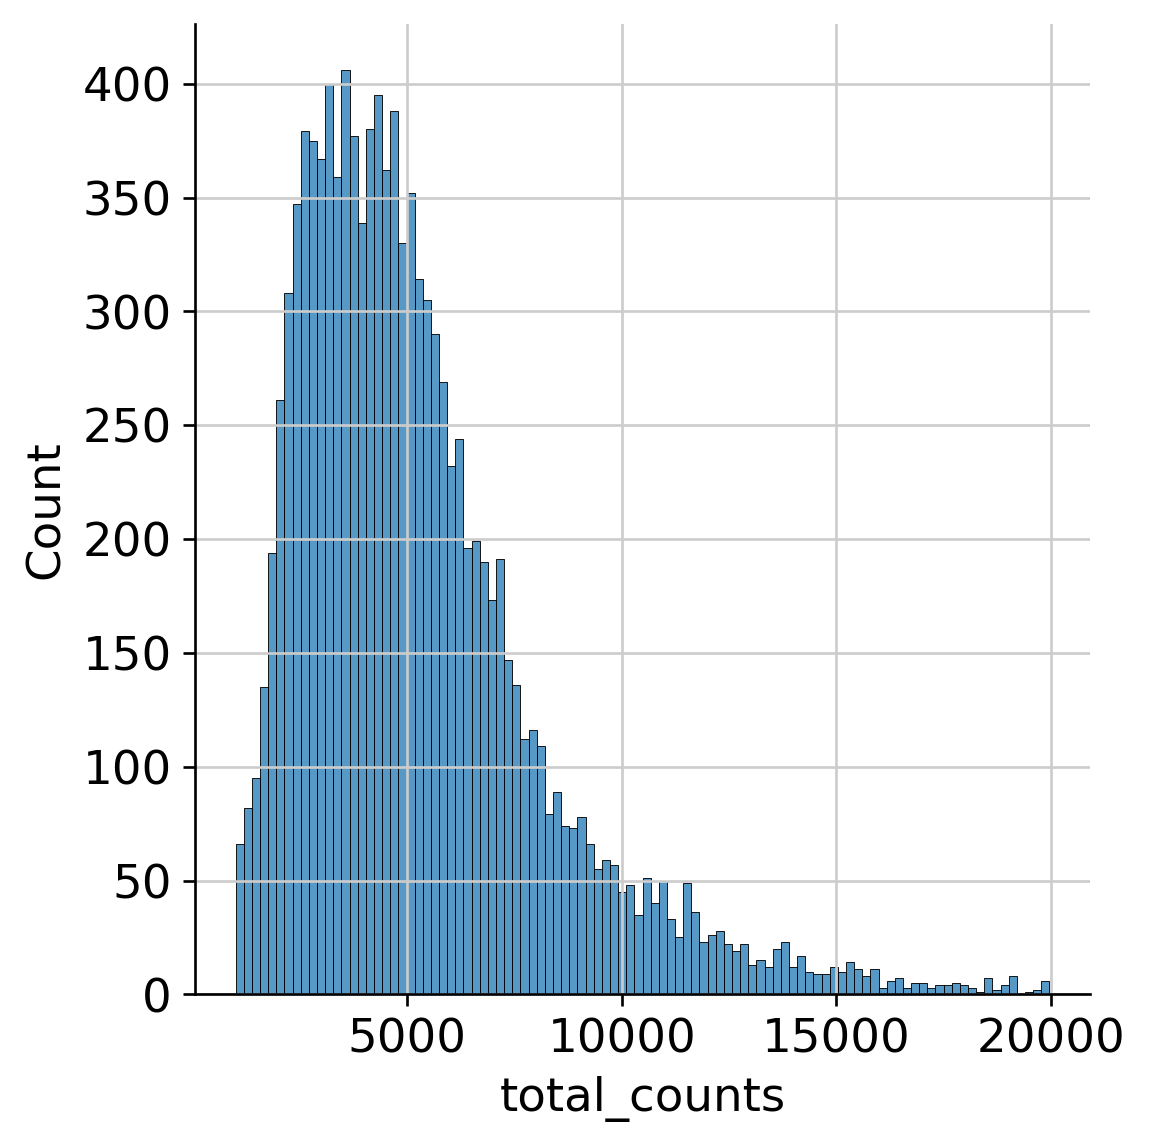

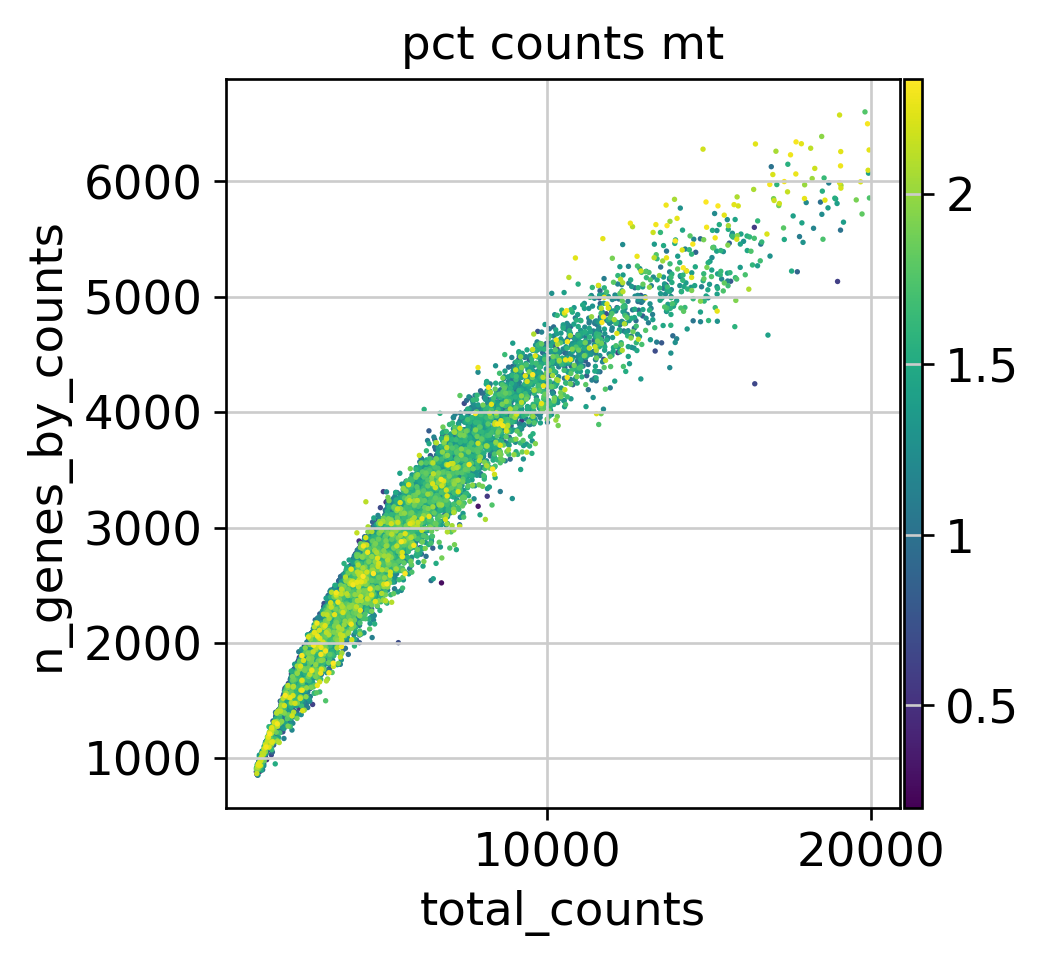

In [9]:
for i in range(0, len(sample)) :
    print('=' * 50)
    print(f' {sample[i]} doublet ver 1 Total number of cells : {data1[i].n_obs}')
    data1[i] = data1[i][(~data1[i].obs.outlier) & (~data1[i].obs.mt_outlier)].copy()
    data1[i].write(path2 + sample[i] + '.scAR.solo1.qc.filter1.h5ad')
    print(f' {sample[i]} doublet ver 1 Number of cells after filtering of low quality cells : {data1[i].n_obs}')
    sc.pl.violin(data1[i], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rb'], jitter = 0, multi_panel = True)
    sns.displot(data1[i].obs["total_counts"], bins = 100, kde = False)
    sc.pl.scatter(data1[i], "total_counts", "n_genes_by_counts", color = "pct_counts_mt")